# Contents
* [Introduction](#Introduction)
* [Imports and configuration](#Imports-and-configuration)
* [Data loading](#Data-loading)
* [Feature reduction](#Feature-reduction)
* [Visualize and explore](#Visualize-and-explore)
* [Discussion](#Discussion)

# Introduction

In this notebook, we use Linear Discriminant Analysis to reduce the development data to two components and visualize them. We also experiment with Local Outlier Factor.

# Imports and configuration

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2021)
del environ
del random_seed
del np_seed
del set_seed
del reset_seeds

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import numpy as np
import pandas as pd

# utility
from gc import collect as gc_collect

# typing
from sklearn.base import BaseEstimator
from typing import Tuple

# metrics
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

# classifiers
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import (
    PassiveAggressiveClassifier,
    LogisticRegressionCV,
    RidgeClassifierCV,
    SGDClassifier,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC

# sklearn misc.
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor

# visualization
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import seaborn as sns

sns.set_context("notebook")
sns.set_style("white")
%matplotlib inline

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

# hide warnings
import warnings

# warnings.filterwarnings("ignore")
del warnings

time: 2.87 s


In [4]:
# Location of FRILL .feather files
FRILL_FEATHERS_FOLDER = "../1.0-mic-extract_FRILL_embeddings"

# Location where this notebook will output
DATA_OUT_FOLDER = "."

_ = gc_collect()

time: 103 ms


# Data loading

In [5]:
keep_columns = [
    "id",
    "source",
    "speaker_id",
    "speaker_gender",
    "emo",
    "valence",
    "neg",
    "neu",
    "lang1",
    "length",
]

data = pd.read_feather(f"{FRILL_FEATHERS_FOLDER}/dev_FRILL.feather").set_index("id")
labels = pd.read_feather(
    f"{FRILL_FEATHERS_FOLDER}/dev_labels.feather", columns=keep_columns
).set_index("id")
del keep_columns
_ = gc_collect()

time: 494 ms


In [6]:
# uncomment lines to undersample data with stratify hack
# from sklearn.model_selection import train_test_split
#
# _, _, _, labels = train_test_split(
#     data,
#     labels,
#     test_size=5000,
#     random_state=SEED,
#     stratify=labels.valence,
# )
# data = data.loc[labels.index]

assert all(data.index == labels.index)
_ = gc_collect()

time: 95.9 ms


# Feature reduction

By default, the number of components LinearDiscrimantAnalysis creates is `min(n_classes - 1, n_features)`. With three classes, this produces two components.

In [7]:
def LDA_fit_transform(df: pd.DataFrame, y: pd.Series) -> Tuple[np.ndarray, np.ndarray]:
    "Fit and transform with linear discriminant analysis"
    transformed_data = LinearDiscriminantAnalysis().fit_transform(df, y)
    return transformed_data[:, 0], transformed_data[:, 1]


_ = gc_collect()

time: 105 ms


In [8]:
X, Y = LDA_fit_transform(data, labels.valence)

time: 14.8 s


Let's take a quick look at these distributions.

In [9]:
def print_stats(xy: np.ndarray) -> None:
    "Display some quick statistics."
    xy = pd.Series(xy)
    print(
        f"mean: {xy.mean()}",
        f"std. dev.: {xy.std()}",
        f"skew: {xy.skew()}",
        f"kurtosis: {xy.kurtosis()}",
        sep="\n",
    )


_ = gc_collect()

time: 108 ms


In [10]:
print_stats(X)
print()
print_stats(Y)

_ = gc_collect()

mean: 3.509566560179809e-15
std. dev.: 1.5403367270613617
skew: 0.8936714197943633
kurtosis: 0.44345049778948953

mean: 8.923225499304382e-15
std. dev.: 1.4148650752712326
skew: 0.5903423859739091
kurtosis: 0.20028426320097292
time: 101 ms


Slight-to-moderate positive skew. The means and standard deviations appear to be on the same scale.

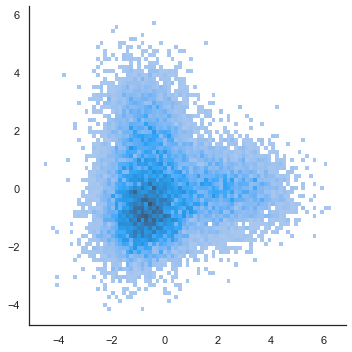

time: 319 ms


In [11]:
sns.displot(x=X, y=Y, palette="colorblind")

Could those be three clusters?

# Visualize and explore

Let's initialize a RidgeClassifier so we can quickly approximate how our manipulations might affect final performance.

In [12]:
make_ridge = lambda: RidgeClassifierCV(
    scoring="balanced_accuracy", cv=3, class_weight="balanced"
)


def score_with_ridge(x: pd.DataFrame, y: pd.Series) -> BaseEstimator:
    """Prints the best score of a RidgeClassifierCV and returns the fitted model"""
    ridge = make_ridge().fit(x, y)
    print(f"best alpha: {ridge.alpha_}")
    print(f"best score: {ridge.best_score_}")
    return ridge


xy_dataframe = lambda X, Y: pd.DataFrame({"X": X, "Y": Y})

_ = gc_collect()

time: 108 ms


In [13]:
ridge = score_with_ridge(data, labels.valence)  # using FRILL features, baseline

best alpha: 10.0
best score: 0.4330484882479399
time: 11.5 s


In [14]:
def plot_df(df):
    sns.scatterplot(
        x=df.X,
        y=df.Y,
        hue=df.hue.replace([0, 1, 2], ["negative", "neutral", "positive"]),
        data=df,
        palette="colorblind",
        alpha=0.7,
        legend="brief",
        linewidth=0,
        marker=".",
        s=50,
    )

    fig = plt.gcf()
    fig.set_figwidth(7)
    fig.set_figheight(7)

    sns.despine(**dict.fromkeys(("top", "right"), True))
    plt.legend(title="valence", frameon=False)
    plt.xlabel("")
    plt.ylabel("")
    plt.suptitle("LDA components")
    plt.show()


_ = gc_collect()

time: 153 ms


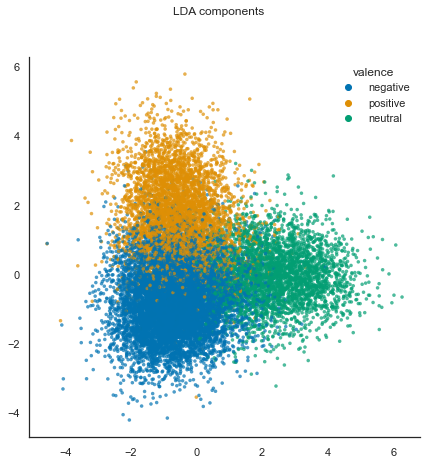

best alpha: 0.1
best score: 0.8448304561921981
time: 817 ms


In [15]:
plot_df(pd.DataFrame({"X": X, "Y": Y, "hue": labels.valence}))
ridge = score_with_ridge(xy_dataframe(X, Y), labels.valence)  # on LDA x and y, no LOF

Hold on, that's one of the best balanced accuracy scores we've seen! Let's pause for a train-test split and cross validate the FRILL -> LDA -> RidgeClassifierCV pipeline.

In [16]:
test_labels = labels[["valence", "speaker_id"]]
_ = gc_collect()

time: 145 ms


<AxesSubplot:xlabel='X', ylabel='Y'>

Text(0.5, 0, '')

Text(0, 0.5, '')

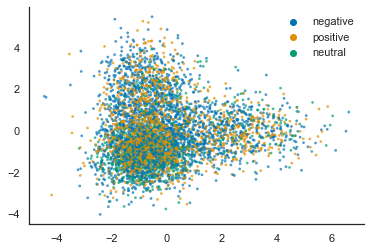

<AxesSubplot:xlabel='X', ylabel='Y'>

Text(0.5, 0, '')

Text(0, 0.5, '')

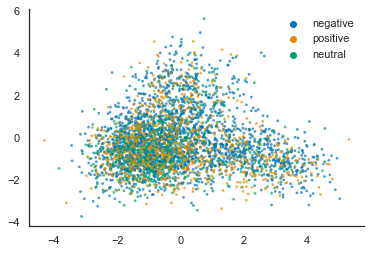

<AxesSubplot:xlabel='X', ylabel='Y'>

Text(0.5, 0, '')

Text(0, 0.5, '')

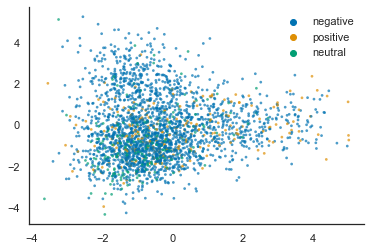

accuracy  balanced_accuracy  adjusted_ba        f1    g-mean
0  0.593553           0.578353     0.367530  0.593810  0.676378
1  0.578947           0.550922     0.326383  0.580804  0.649000
2  0.585569           0.540486     0.310730  0.584622  0.640439

mean accuracy score 0.5860228573937276
mean balanced_accuracy score 0.5565871541088622
mean adjusted_ba score 0.3348807311632933
mean f1 score 0.5864120182481019
mean g-mean score 0.6552727136678312
time: 35.6 s


In [17]:
scores = {
    "accuracy": [],
    "balanced_accuracy": [],
    "adjusted_ba": [],
    "f1": [],
    "g-mean": [],
}

for train_idx, test_idx in StratifiedGroupKFold(
    n_splits=3, shuffle=True, random_state=SEED
).split(X=data, y=test_labels.valence, groups=test_labels.speaker_id):
    X_train, y_train = data.iloc[train_idx], test_labels.iloc[train_idx].valence
    X_test, y_test = data.iloc[test_idx], test_labels.iloc[test_idx].valence
    reducer = LinearDiscriminantAnalysis().fit(X_train, y_train)
    X_train, X_test = reducer.transform(X_train), reducer.transform(X_test)
    temp = pd.DataFrame({"X": X_train[:, 0], "Y": X_train[:, 1]})
    sns.scatterplot(
        x=temp.X,
        y=temp.Y,
        hue=y_train.replace([0, 1, 2], ["negative", "neutral", "positive"]),
        palette="colorblind",
        alpha=0.7,
        legend="brief",
        linewidth=0,
        marker=".",
        s=30,
    )
    sns.despine(**dict.fromkeys(("top", "right"), True))
    plt.legend(frameon=False)
    plt.xlabel("")
    plt.ylabel("")
    del temp
    _ = gc_collect()
    plt.show()
    model = RidgeClassifierCV(
        scoring="balanced_accuracy", cv=3, class_weight="balanced"
    ).fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores["accuracy"].append(accuracy_score(y_test, y_pred))
    scores["balanced_accuracy"].append(balanced_accuracy_score(y_test, y_pred))
    scores["adjusted_ba"].append(balanced_accuracy_score(y_test, y_pred, adjusted=True))
    scores["f1"].append(f1_score(y_test, y_pred, average="weighted"))
    scores["g-mean"].append(geometric_mean_score(y_test, y_pred, average="weighted"))
results = pd.DataFrame(scores)
results
for column in results.columns:
    print(f"mean {column} score {results[column].mean()}")

What's the decision region like?

In [18]:
def plot_decision_regions_(df: pd.DataFrame, y: pd.Series, clf: BaseEstimator) -> None:
    """Calls mlxtend's plot_decision_regions"""
    df = df[["X", "Y"]]
    plot_decision_regions(
        df.values,
        y.values,
        clf=clf,
    )
    plt.show()


_ = gc_collect()

time: 125 ms


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RidgeClassifierCV was fitted with feature names
  warnings.warn(


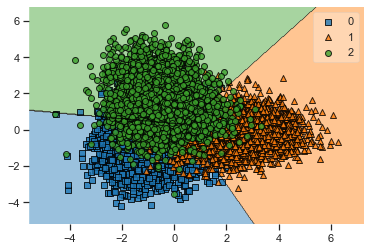

time: 293 ms


In [19]:
plot_decision_regions_(xy_dataframe(X, Y), labels.valence, ridge)

Dimensionality reduction alone may improve performance.

In [20]:
def remove_outliers(df: pd.DataFrame) -> pd.DataFrame:
    """Remove outliers with LOF"""
    size = len(df)
    df = df.loc[LocalOutlierFactor(n_jobs=-1).fit_predict(df) == 1]
    print(f"removed {size - len(df)} outliers")
    return df


_ = gc_collect()

time: 107 ms


After outlier removal

In [21]:
data_lof = remove_outliers(data)
labels.index = data.index
labels_lof = labels.loc[data_lof.index]
ridge = score_with_ridge(data_lof, labels_lof.valence)  # FRILL features minus outliers

removed 456 outliers
best alpha: 10.0
best score: 0.4279981798843901
time: 32.8 s


Removing outliers may be useful as well, especially in conjunction with subsequent dimensionality reduction.

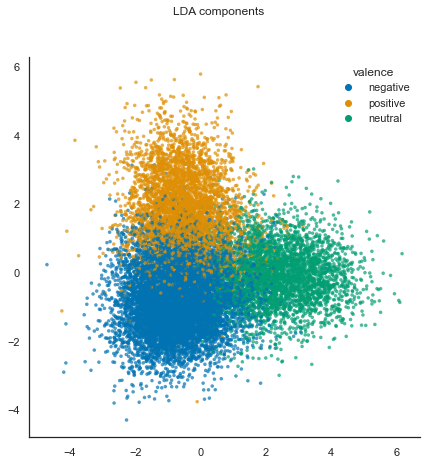

best alpha: 0.1
best score: 0.8489170011790974
time: 15.4 s


In [22]:
# frill features minus outliers, LDA x y
X_lof, Y_lof = LDA_fit_transform(data_lof, labels_lof.valence)
plot_df(pd.DataFrame({"X": X_lof, "Y": Y_lof, "hue": labels_lof.valence}))
ridge = score_with_ridge(lof_df := xy_dataframe(X_lof, Y_lof), labels_lof.valence)
lof_df.index = data_lof.index
del X_lof
del Y_lof
_ = gc_collect()

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RidgeClassifierCV was fitted with feature names
  warnings.warn(


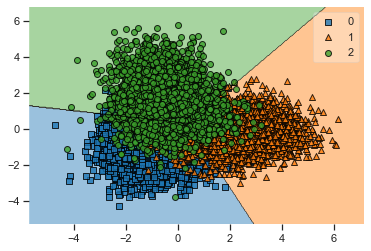

time: 275 ms


In [23]:
plot_decision_regions_(lof_df, labels_lof.loc[lof_df.index].valence, ridge)

What if I remove outliers by class too?

In [24]:
df_double_lof = pd.concat(
    [remove_outliers(data_lof.loc[labels_lof.valence == i]) for i in range(3)]
)
labels_double_lof = labels_lof.loc[df_double_lof.index]
df_double_lof

removed 144 outliers
removed 58 outliers
removed 41 outliers


0         1         2         3         4         5         6  \
id                                                                            
0      0.119926 -0.049218  0.039702  0.141101  0.044318  0.049631  0.016178   
2      0.101377 -0.063714 -0.015971 -0.151561 -0.065328 -0.013746  0.008821   
4     -0.028015 -0.041617  0.012599 -0.031460  0.021788  0.039503  0.033654   
6     -0.008712 -0.003798 -0.052170  0.030298  0.049662  0.039806  0.056743   
8     -0.000265 -0.050629 -0.005011 -0.169305 -0.087526 -0.022268 -0.020403   
...         ...       ...       ...       ...       ...       ...       ...   
38041  0.064168  0.000253  0.014750 -0.099780  0.076748 -0.071654 -0.114463   
38042  0.198948  0.037827 -0.009440  0.054333  0.000664 -0.038850 -0.149312   
38043  0.090211  0.082888  0.038682 -0.039086  0.038133 -0.036152 -0.031437   
38044  0.160677  0.038019  0.012688  0.152278  0.046136 -0.039934 -0.203254   
38045  0.024110  0.115350 -0.066420  0.106654  0.095533 -0.120082 -0.124346   

              7         8         9  ...      2038      2039      2040  \
id                                   ...                                 
0      0.025797 -0.104466 -0.016044  ... -0.226529 -0.091773  0.028184   
2      0.010461 -0.030857 -0.010367  ... -0.169826  0.051789  0.114774   
4      0.114422 -0.080653 -0.032090  ...  0.059661  0.020316  0.044898   
6     -0.186714 -0.151110  0.021191  ...  0.107442  0.053569 -0.067552   
8     -0.149949 -0.047235  0.032980  ... -0.128375  0.128055  0.047202   
...         ...       ...       ...  ...       ...       ...       ...   
38041  0.035970 -0.011269 -0.060001  ...  0.022307  0.191061 -0.018378   
38042  0.094249 -0.063833  0.127064  ... -0.038456  0.089105 -0.029307   
38043  0.062903  0.093598  0.086369  ... -0.110583  0.045120  0.045117   
38044  0.062654  0.038210  0.063746  ...  0.228180  0.108334 -0.051334   
38045  0.007174 -0.010640 -0.047329  ... -0.059131  0.087166  0.023696   

           2041      2042      2043      2044      2045      2046      2047  
id                                                                           
0     -0.074794  0.025474  0.046511 -0.002693 -0.017953 -0.146394 -0.062330  
2     -0.033263 -0.071615 -0.040535 -0.050813  0.021136 -0.189459  0.040756  
4      0.008499  0.009812 -0.047551  0.085392  0.029538  0.057070 -0.029945  
6     -0.017051 -0.109469 -0.082999 -0.049325  0.031638 -0.027172  0.006479  
8     -0.024305 -0.168291  0.112876  0.017571  0.078376  0.099279 -0.046610  
...         ...       ...       ...       ...       ...       ...       ...  
38041 -0.160262  0.006271 -0.061425  0.071048  0.003422  0.017843  0.001376  
38042 -0.015380  0.055569 -0.001771  0.006522  0.046066  0.104873 -0.107413  
38043  0.033105  0.029635  0.027369  0.009176 -0.107435  0.005265  0.085583  
38044 -0.051817  0.042509  0.021591 -0.066362  0.057843  0.065498  0.006523  
38045 -0.159608 -0.046683  0.025995  0.008598  0.124754  0.111951 -0.165759  

[17004 rows x 2048 columns]

time: 8.89 s


In [25]:
del data_lof
del labels_lof
_ = gc_collect()

time: 107 ms


In [26]:
ridge = score_with_ridge(df_double_lof, labels_double_lof.valence)

best alpha: 1.0
best score: 0.4246250743576634
time: 10.6 s


LOF outlier removal alone may hurt performance without LDA feature reduction.

In [27]:
X_double_lof, Y_double_lof = LDA_fit_transform(df_double_lof, labels_double_lof.valence)

time: 14.3 s


In [28]:
del df_double_lof
_ = gc_collect()

time: 102 ms


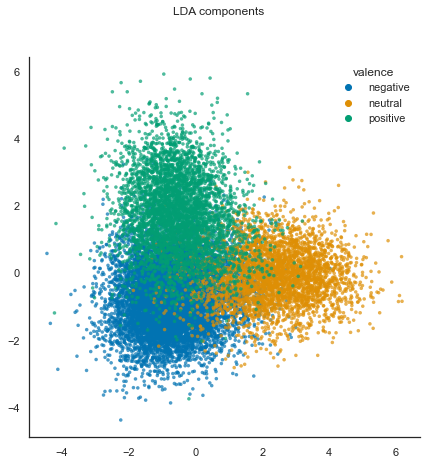

time: 473 ms


In [29]:
plot_df(
    pd.DataFrame(
        {"X": X_double_lof, "Y": Y_double_lof, "hue": labels_double_lof.valence}
    )
)

In [30]:
ridge = score_with_ridge(
    xy_dataframe(X_double_lof, Y_double_lof), labels_double_lof.valence
)

best alpha: 0.1
best score: 0.8533917374887613
time: 99.5 ms


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RidgeClassifierCV was fitted with feature names
  warnings.warn(


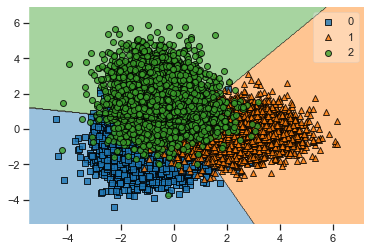

time: 282 ms


In [31]:
plot_decision_regions_(
    xy_dataframe(X_double_lof, Y_double_lof), labels_double_lof.valence, ridge
)

Let's try a LOF-LDA-per_class_LOF double removal.

In [32]:
del X_double_lof
del Y_double_lof
_ = gc_collect()

time: 98.9 ms


In [33]:
lof_lda_classlof = pd.concat(
    [
        remove_outliers(lof_df.loc[labels_double_lof.query(f"valence == {i}").index])
        for i in range(3)
    ]
)
len(lof_df)
len(lof_lda_classlof)

removed 44 outliers
removed 34 outliers
removed 43 outliers


17247

16883

time: 124 ms


In [34]:
del labels_double_lof
_ = gc_collect()

time: 111 ms


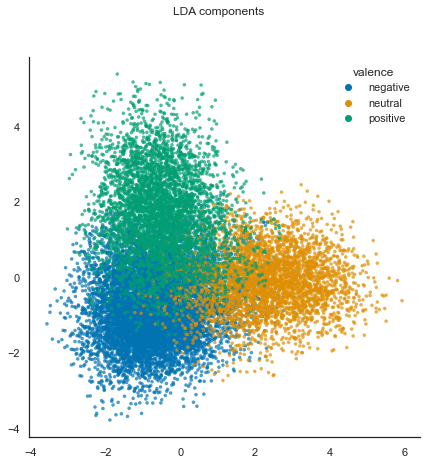

time: 444 ms


In [35]:
lof_lda_classlof["hue"] = labels.loc[lof_lda_classlof.index].valence
plot_df(lof_lda_classlof)

In [36]:
ridge = score_with_ridge(lof_lda_classlof.drop(columns="hue"), lof_lda_classlof.hue)

best alpha: 0.1
best score: 0.8553811371632568
time: 99 ms


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RidgeClassifierCV was fitted with feature names
  warnings.warn(


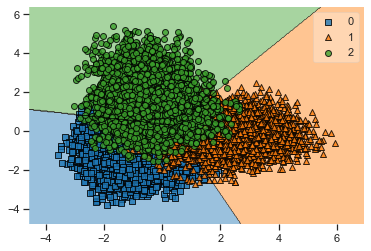

time: 303 ms


In [37]:
plot_decision_regions_(
    lof_lda_classlof.drop(columns="hue"), lof_lda_classlof.hue, ridge
)

In [38]:
del ridge
_ = gc_collect()

time: 106 ms


In [39]:
final_test_labels = labels.loc[lof_lda_classlof.index]
final_test_df = lof_lda_classlof.drop("hue", axis="columns")
_ = gc_collect()

time: 114 ms


In [40]:
del lof_lda_classlof
_ = gc_collect()

time: 106 ms


In [41]:
test_labels = labels[["valence", "speaker_id"]]
del X
del Y

_ = gc_collect

time: 2.03 ms


removed 36 outliers
removed 26 outliers
removed 30 outliers


<AxesSubplot:xlabel='0', ylabel='1'>

Text(0.5, 0, '')

Text(0, 0.5, '')

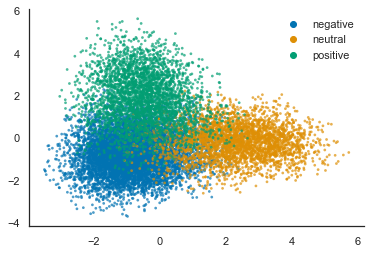

removed 41 outliers
removed 33 outliers
removed 35 outliers


<AxesSubplot:xlabel='0', ylabel='1'>

Text(0.5, 0, '')

Text(0, 0.5, '')

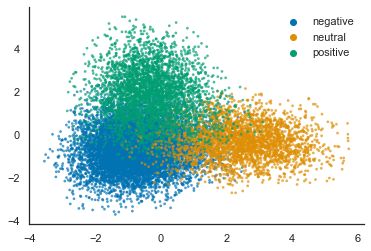

removed 61 outliers
removed 37 outliers
removed 34 outliers


<AxesSubplot:xlabel='0', ylabel='1'>

Text(0.5, 0, '')

Text(0, 0.5, '')

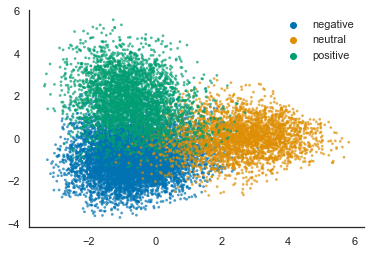

removed 47 outliers
removed 17 outliers
removed 44 outliers


<AxesSubplot:xlabel='0', ylabel='1'>

Text(0.5, 0, '')

Text(0, 0.5, '')

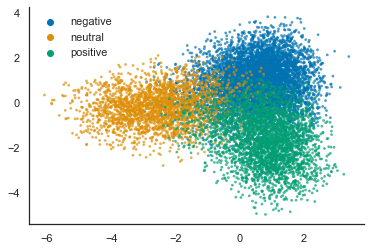

removed 45 outliers
removed 35 outliers
removed 34 outliers


<AxesSubplot:xlabel='0', ylabel='1'>

Text(0.5, 0, '')

Text(0, 0.5, '')

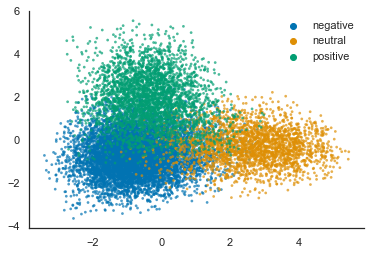

accuracy  balanced_accuracy  adjusted_ba        f1    g-mean
0  0.604762           0.530290     0.295434  0.589186  0.614525
1  0.550589           0.546628     0.319942  0.546363  0.644264
2  0.547258           0.523027     0.284540  0.561606  0.628454
3  0.582575           0.517326     0.275990  0.584667  0.640014
4  0.572507           0.571682     0.357523  0.574137  0.664071

mean accuracy score 0.5715380502530761
mean balanced_accuracy score 0.5377906458964893
mean adjusted_ba score 0.3066859688447339
mean f1 score 0.5711917808231333
mean g-mean score 0.6382657983223671
time: 2min 19s


In [42]:
scores = {
    "accuracy": [],
    "balanced_accuracy": [],
    "adjusted_ba": [],
    "f1": [],
    "g-mean": [],
}

for train_idx, test_idx in StratifiedGroupKFold(
    n_splits=5, shuffle=True, random_state=SEED
).split(X=data, y=test_labels.valence, groups=test_labels.speaker_id):
    # load
    X_train = data.iloc[train_idx]

    # remove outliers
    X_train = X_train.loc[LocalOutlierFactor(n_jobs=-1).fit_predict(X_train) == 1]
    train_index = X_train.index
    y_train = test_labels.loc[train_index].valence

    # reduce dimensions
    reducer = LinearDiscriminantAnalysis().fit(X_train, y_train)
    X_train = pd.DataFrame(reducer.transform(X_train))
    X_train.index = train_index
    del train_index
    _ = gc_collect()

    # remove outliers per class
    X_train = pd.concat([remove_outliers(X_train.loc[y_train == i]) for i in range(3)])
    y_train = test_labels.loc[X_train.index].valence

    # visualize
    sns.scatterplot(
        x=X_train[0],
        y=X_train[1],
        hue=y_train.replace([0, 1, 2], ["negative", "neutral", "positive"]),
        palette="colorblind",
        alpha=0.7,
        legend="brief",
        linewidth=0,
        marker=".",
        s=30,
    )
    sns.despine(**dict.fromkeys(("top", "right"), True))
    plt.legend(frameon=False)
    plt.xlabel("")
    plt.ylabel("")
    plt.show()

    # initialize model
    model = RidgeClassifierCV(
        scoring="balanced_accuracy", cv=3, class_weight="balanced"
    ).fit(X_train, y_train)
    del X_train
    del y_train
    _ = gc_collect()

    # load and predict y
    y_pred = model.predict(reducer.transform(data.iloc[test_idx]))
    del model
    del reducer
    _ = gc_collect()
    y_test = test_labels.iloc[test_idx].valence

    # score
    scores["accuracy"].append(accuracy_score(y_test, y_pred))
    scores["balanced_accuracy"].append(balanced_accuracy_score(y_test, y_pred))
    scores["adjusted_ba"].append(balanced_accuracy_score(y_test, y_pred, adjusted=True))
    scores["f1"].append(f1_score(y_test, y_pred, average="weighted"))
    scores["g-mean"].append(geometric_mean_score(y_test, y_pred, average="weighted"))

    del y_test
    del y_pred
    _ = gc_collect()

results = pd.DataFrame(scores)
results
for column in results.columns:
    print(f"mean {column} score {results[column].mean()}")

In [43]:
scores = {
    "accuracy": [],
    "balanced_accuracy": [],
    "adjusted_ba": [],
    "f1": [],
    "g-mean": [],
}

for train_idx, test_idx in StratifiedGroupKFold(
    n_splits=5, shuffle=True, random_state=SEED
).split(X=data, y=test_labels.valence, groups=test_labels.speaker_id):
    # load
    X_train = data.iloc[train_idx]

    # remove outliers
    X_train = X_train.loc[LocalOutlierFactor(n_jobs=-1).fit_predict(X_train) == 1]
    train_index = X_train.index
    y_train = test_labels.loc[train_index].valence

    # reduce dimensions
    reducer = LinearDiscriminantAnalysis().fit(X_train, y_train)
    X_train = pd.DataFrame(reducer.transform(X_train))
    X_train.index = train_index
    del train_index
    _ = gc_collect()

    # remove outliers per class
    X_train = pd.concat([remove_outliers(X_train.loc[y_train == i]) for i in range(3)])
    y_train = test_labels.loc[X_train.index].valence

    # # visualize
    # sns.scatterplot(
    #     x=X_train[0],
    #     y=X_train[1],
    #     hue=y_train.replace([0, 1, 2], ["negative", "neutral", "positive"]),
    #     palette="colorblind",
    #     alpha=0.7,
    #     legend="brief",
    #     linewidth=0,
    #     marker=".",
    #     s=30,
    # )
    # sns.despine(**dict.fromkeys(("top", "right"), True))
    # plt.legend(frameon=False)
    # plt.xlabel("")
    # plt.ylabel("")
    # plt.show()
    
    # initialize model
    model = LinearSVC(class_weight="balanced", random_state=SEED).fit(X_train, y_train)
    del X_train
    del y_train
    _ = gc_collect()

    # load and predict y
    y_pred = model.predict(reducer.transform(data.iloc[test_idx]))
    del model
    del reducer
    _ = gc_collect()
    y_test = test_labels.iloc[test_idx].valence

    # score
    scores["accuracy"].append(accuracy_score(y_test, y_pred))
    scores["balanced_accuracy"].append(balanced_accuracy_score(y_test, y_pred))
    scores["adjusted_ba"].append(balanced_accuracy_score(y_test, y_pred, adjusted=True))
    scores["f1"].append(f1_score(y_test, y_pred, average="weighted"))
    scores["g-mean"].append(geometric_mean_score(y_test, y_pred, average="weighted"))

    del y_test
    del y_pred
    _ = gc_collect()

results = pd.DataFrame(scores)
results
for column in results.columns:
    print(f"mean {column} score {results[column].mean()}")

removed 36 outliers
removed 26 outliers
removed 30 outliers
removed 41 outliers
removed 33 outliers
removed 35 outliers
removed 61 outliers
removed 37 outliers
removed 34 outliers
removed 47 outliers
removed 17 outliers
removed 44 outliers
removed 45 outliers
removed 35 outliers
removed 34 outliers


accuracy  balanced_accuracy  adjusted_ba        f1    g-mean
0  0.616667           0.527946     0.291918  0.593904  0.613422
1  0.555059           0.544238     0.316357  0.547421  0.644070
2  0.551147           0.509079     0.263618  0.562655  0.620680
3  0.589181           0.509514     0.264271  0.587912  0.635403
4  0.573854           0.563651     0.345476  0.574547  0.660844

mean accuracy score 0.5771815900367802
mean balanced_accuracy score 0.5308855333830994
mean adjusted_ba score 0.29632830007464916
mean f1 score 0.5732878021220349
mean g-mean score 0.6348837846406694
time: 2min 17s


removed 36 outliers
removed 26 outliers
removed 30 outliers


<AxesSubplot:xlabel='0', ylabel='1'>

Text(0.5, 0, '')

Text(0, 0.5, '')

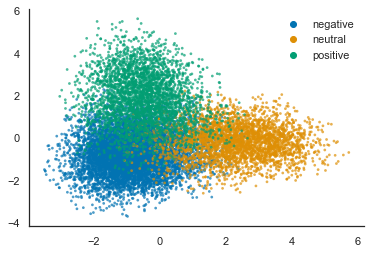

removed 41 outliers
removed 33 outliers
removed 35 outliers


<AxesSubplot:xlabel='0', ylabel='1'>

Text(0.5, 0, '')

Text(0, 0.5, '')

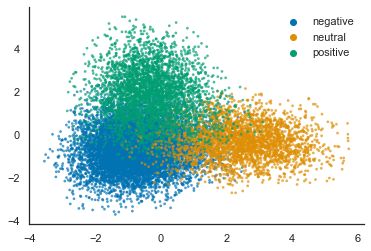

removed 61 outliers
removed 37 outliers
removed 34 outliers


<AxesSubplot:xlabel='0', ylabel='1'>

Text(0.5, 0, '')

Text(0, 0.5, '')

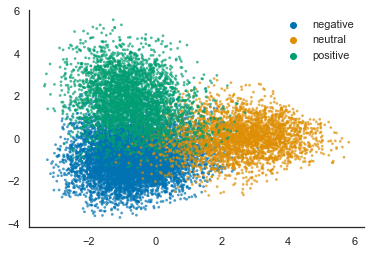

removed 47 outliers
removed 17 outliers
removed 44 outliers


<AxesSubplot:xlabel='0', ylabel='1'>

Text(0.5, 0, '')

Text(0, 0.5, '')

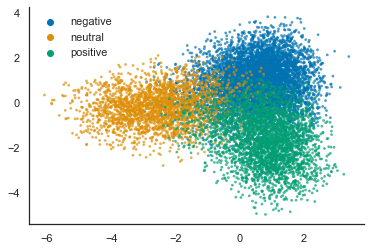

removed 45 outliers
removed 35 outliers
removed 34 outliers


<AxesSubplot:xlabel='0', ylabel='1'>

Text(0.5, 0, '')

Text(0, 0.5, '')

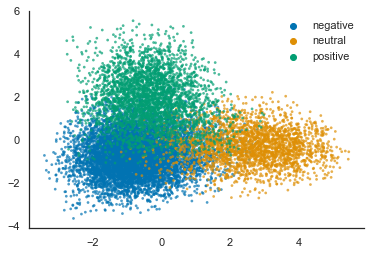

accuracy  balanced_accuracy  adjusted_ba        f1    g-mean
0  0.598810           0.528298     0.292447  0.586556  0.613287
1  0.551402           0.547956     0.321934  0.548006  0.644582
2  0.541813           0.517316     0.275974  0.556094  0.622759
3  0.575969           0.520729     0.281094  0.580798  0.640724
4  0.567116           0.569208     0.353813  0.569011  0.660822

mean accuracy score 0.5670216794565566
mean balanced_accuracy score 0.5367015682609917
mean adjusted_ba score 0.30505235239148754
mean f1 score 0.5680930650992373
mean g-mean score 0.6364347644181878
time: 2min 22s


In [60]:
scores = {
    "accuracy": [],
    "balanced_accuracy": [],
    "adjusted_ba": [],
    "f1": [],
    "g-mean": [],
}

for train_idx, test_idx in StratifiedGroupKFold(
    n_splits=5, shuffle=True, random_state=SEED
).split(X=data, y=test_labels.valence, groups=test_labels.speaker_id):
    # load
    X_train = data.iloc[train_idx]

    # remove outliers
    X_train = X_train.loc[LocalOutlierFactor(n_jobs=-1).fit_predict(X_train) == 1]
    train_index = X_train.index
    y_train = test_labels.loc[train_index].valence

    # reduce dimensions
    reducer = LinearDiscriminantAnalysis().fit(X_train, y_train)
    X_train = pd.DataFrame(reducer.transform(X_train))
    X_train.index = train_index
    del train_index
    _ = gc_collect()

    # remove outliers per class
    X_train = pd.concat([remove_outliers(X_train.loc[y_train == i]) for i in range(3)])
    y_train = test_labels.loc[X_train.index].valence

    # visualize
    sns.scatterplot(
        x=X_train[0],
        y=X_train[1],
        hue=y_train.replace([0, 1, 2], ["negative", "neutral", "positive"]),
        palette="colorblind",
        alpha=0.7,
        legend="brief",
        linewidth=0,
        marker=".",
        s=30,
    )
    sns.despine(**dict.fromkeys(("top", "right"), True))
    plt.legend(frameon=False)
    plt.xlabel("")
    plt.ylabel("")
    plt.show()

    # initialize model
    model = LogisticRegressionCV(
        scoring="balanced_accuracy",
        class_weight="balanced",
        n_jobs=-1,
        random_state=SEED,
    ).fit(X_train, y_train)
    del X_train
    del y_train
    _ = gc_collect()

    # load and predict y
    y_pred = model.predict(reducer.transform(data.iloc[test_idx]))
    del model
    del reducer
    _ = gc_collect()
    y_test = test_labels.iloc[test_idx].valence

    # score
    scores["accuracy"].append(accuracy_score(y_test, y_pred))
    scores["balanced_accuracy"].append(balanced_accuracy_score(y_test, y_pred))
    scores["adjusted_ba"].append(balanced_accuracy_score(y_test, y_pred, adjusted=True))
    scores["f1"].append(f1_score(y_test, y_pred, average="weighted"))
    scores["g-mean"].append(geometric_mean_score(y_test, y_pred, average="weighted"))

    del y_test
    del y_pred
    _ = gc_collect()

results = pd.DataFrame(scores)
results
for column in results.columns:
    print(f"mean {column} score {results[column].mean()}")

In [45]:
scores = {
    "accuracy": [],
    "balanced_accuracy": [],
    "adjusted_ba": [],
    "f1": [],
    "g-mean": [],
}

for train_idx, test_idx in StratifiedGroupKFold(
    n_splits=5, shuffle=True, random_state=SEED
).split(X=data, y=test_labels.valence, groups=test_labels.speaker_id):
    # load
    X_train = data.iloc[train_idx]

    # remove outliers
    X_train = X_train.loc[LocalOutlierFactor(n_jobs=-1).fit_predict(X_train) == 1]
    train_index = X_train.index
    y_train = test_labels.loc[train_index].valence

    # reduce dimensions
    reducer = LinearDiscriminantAnalysis().fit(X_train, y_train)
    X_train = pd.DataFrame(reducer.transform(X_train))
    X_train.index = train_index
    del train_index
    _ = gc_collect()

    # remove outliers per class
    X_train = pd.concat([remove_outliers(X_train.loc[y_train == i]) for i in range(3)])
    y_train = test_labels.loc[X_train.index].valence

    # # visualize
    # sns.scatterplot(
    #     x=X_train[0],
    #     y=X_train[1],
    #     hue=y_train.replace([0, 1, 2], ["negative", "neutral", "positive"]),
    #     palette="colorblind",
    #     alpha=0.7,
    #     legend="brief",
    #     linewidth=0,
    #     marker=".",
    #     s=30,
    # )
    # sns.despine(**dict.fromkeys(("top", "right"), True))
    # plt.legend(frameon=False)
    # plt.xlabel("")
    # plt.ylabel("")
    # plt.show()

    # initialize model
    model = SGDClassifier(n_jobs=-1, random_state=SEED, class_weight="balanced").fit(
        X_train, y_train
    )
    del X_train
    del y_train
    _ = gc_collect()

    # load and predict y
    y_pred = model.predict(reducer.transform(data.iloc[test_idx]))
    del model
    del reducer
    _ = gc_collect()
    y_test = test_labels.iloc[test_idx].valence

    # score
    scores["accuracy"].append(accuracy_score(y_test, y_pred))
    scores["balanced_accuracy"].append(balanced_accuracy_score(y_test, y_pred))
    scores["adjusted_ba"].append(balanced_accuracy_score(y_test, y_pred, adjusted=True))
    scores["f1"].append(f1_score(y_test, y_pred, average="weighted"))
    scores["g-mean"].append(geometric_mean_score(y_test, y_pred, average="weighted"))

    del y_test
    del y_pred
    _ = gc_collect()

results = pd.DataFrame(scores)
results
for column in results.columns:
    print(f"mean {column} score {results[column].mean()}")

removed 36 outliers
removed 26 outliers
removed 30 outliers
removed 41 outliers
removed 33 outliers
removed 35 outliers
removed 61 outliers
removed 37 outliers
removed 34 outliers
removed 47 outliers
removed 17 outliers
removed 44 outliers
removed 45 outliers
removed 35 outliers
removed 34 outliers


accuracy  balanced_accuracy  adjusted_ba        f1    g-mean
0  0.617560           0.531043     0.296564  0.601640  0.619030
1  0.556278           0.540545     0.310818  0.548881  0.643108
2  0.549592           0.509650     0.264475  0.561435  0.619770
3  0.581860           0.513153     0.269730  0.585891  0.634165
4  0.576280           0.566919     0.350378  0.576818  0.662643

mean accuracy score 0.5763139527465022
mean balanced_accuracy score 0.5322620371549625
mean adjusted_ba score 0.2983930557324437
mean f1 score 0.5749328617458996
mean g-mean score 0.6357432629762567
time: 2min 13s


In [46]:
scores = {
    "accuracy": [],
    "balanced_accuracy": [],
    "adjusted_ba": [],
    "f1": [],
    "g-mean": [],
}

for train_idx, test_idx in StratifiedGroupKFold(
    n_splits=5, shuffle=True, random_state=SEED
).split(X=data, y=test_labels.valence, groups=test_labels.speaker_id):
    # load
    X_train = data.iloc[train_idx]

    # remove outliers
    X_train = X_train.loc[LocalOutlierFactor(n_jobs=-1).fit_predict(X_train) == 1]
    train_index = X_train.index
    y_train = test_labels.loc[train_index].valence

    # reduce dimensions
    reducer = LinearDiscriminantAnalysis().fit(X_train, y_train)
    X_train = pd.DataFrame(reducer.transform(X_train))
    X_train.index = train_index
    del train_index
    _ = gc_collect()

    # remove outliers per class
    X_train = pd.concat([remove_outliers(X_train.loc[y_train == i]) for i in range(3)])
    y_train = test_labels.loc[X_train.index].valence

    # # visualize
    # sns.scatterplot(
    #     x=X_train[0],
    #     y=X_train[1],
    #     hue=y_train.replace([0, 1, 2], ["negative", "neutral", "positive"]),
    #     palette="colorblind",
    #     alpha=0.7,
    #     legend="brief",
    #     linewidth=0,
    #     marker=".",
    #     s=30,
    # )
    # sns.despine(**dict.fromkeys(("top", "right"), True))
    # plt.legend(frameon=False)
    # plt.xlabel("")
    # plt.ylabel("")
    # plt.show()

    # initialize model
    model = GaussianProcessClassifier(random_state=SEED, n_jobs=-1).fit(
        X_train, y_train
    )
    del X_train
    del y_train
    _ = gc_collect()

    # load and predict y
    y_pred = model.predict(reducer.transform(data.iloc[test_idx]))
    del model
    del reducer
    _ = gc_collect()
    y_test = test_labels.iloc[test_idx].valence

    # score
    scores["accuracy"].append(accuracy_score(y_test, y_pred))
    scores["balanced_accuracy"].append(balanced_accuracy_score(y_test, y_pred))
    scores["adjusted_ba"].append(balanced_accuracy_score(y_test, y_pred, adjusted=True))
    scores["f1"].append(f1_score(y_test, y_pred, average="weighted"))
    scores["g-mean"].append(geometric_mean_score(y_test, y_pred, average="weighted"))

    del y_test
    del y_pred
    _ = gc_collect()

results = pd.DataFrame(scores)
results
for column in results.columns:
    print(f"mean {column} score {results[column].mean()}")

removed 36 outliers
removed 26 outliers
removed 30 outliers
removed 41 outliers
removed 33 outliers
removed 35 outliers
removed 61 outliers
removed 37 outliers
removed 34 outliers
removed 47 outliers
removed 17 outliers
removed 44 outliers
removed 45 outliers
removed 35 outliers
removed 34 outliers


accuracy  balanced_accuracy  adjusted_ba        f1    g-mean
0  0.630655           0.515998     0.273996  0.594948  0.605629
1  0.548557           0.528529     0.292793  0.533101  0.633091
2  0.577596           0.509009     0.263514  0.581723  0.625299
3  0.606142           0.508633     0.262950  0.598821  0.637506
4  0.572237           0.548619     0.322928  0.568854  0.650928

mean accuracy score 0.5870374964133976
mean balanced_accuracy score 0.5221575448124037
mean adjusted_ba score 0.28323631721860565
mean f1 score 0.5754893007815751
mean g-mean score 0.6304906903300453
time: 2h 21min 16s


In [47]:
scores = {
    "accuracy": [],
    "balanced_accuracy": [],
    "adjusted_ba": [],
    "f1": [],
    "g-mean": [],
}

for train_idx, test_idx in StratifiedGroupKFold(
    n_splits=5, shuffle=True, random_state=SEED
).split(X=data, y=test_labels.valence, groups=test_labels.speaker_id):
    # load
    X_train = data.iloc[train_idx]

    # remove outliers
    X_train = X_train.loc[LocalOutlierFactor(n_jobs=-1).fit_predict(X_train) == 1]
    train_index = X_train.index
    y_train = test_labels.loc[train_index].valence

    # reduce dimensions
    reducer = LinearDiscriminantAnalysis().fit(X_train, y_train)
    X_train = pd.DataFrame(reducer.transform(X_train))
    X_train.index = train_index
    del train_index
    _ = gc_collect()

    # remove outliers per class
    X_train = pd.concat([remove_outliers(X_train.loc[y_train == i]) for i in range(3)])
    y_train = test_labels.loc[X_train.index].valence

    # # visualize
    # sns.scatterplot(
    #     x=X_train[0],
    #     y=X_train[1],
    #     hue=y_train.replace([0, 1, 2], ["negative", "neutral", "positive"]),
    #     palette="colorblind",
    #     alpha=0.7,
    #     legend="brief",
    #     linewidth=0,
    #     marker=".",
    #     s=30,
    # )
    # sns.despine(**dict.fromkeys(("top", "right"), True))
    # plt.legend(frameon=False)
    # plt.xlabel("")
    # plt.ylabel("")
    # plt.show()

    # initialize model
    model = KNeighborsClassifier(n_jobs=-1).fit(X_train, y_train)
    del X_train
    del y_train
    _ = gc_collect()

    # load and predict y
    y_pred = model.predict(reducer.transform(data.iloc[test_idx]))
    del model
    del reducer
    _ = gc_collect()
    y_test = test_labels.iloc[test_idx].valence

    # score
    scores["accuracy"].append(accuracy_score(y_test, y_pred))
    scores["balanced_accuracy"].append(balanced_accuracy_score(y_test, y_pred))
    scores["adjusted_ba"].append(balanced_accuracy_score(y_test, y_pred, adjusted=True))
    scores["f1"].append(f1_score(y_test, y_pred, average="weighted"))
    scores["g-mean"].append(geometric_mean_score(y_test, y_pred, average="weighted"))

    del y_test
    del y_pred
    _ = gc_collect()

results = pd.DataFrame(scores)
results
for column in results.columns:
    print(f"mean {column} score {results[column].mean()}")

removed 36 outliers
removed 26 outliers
removed 30 outliers
removed 41 outliers
removed 33 outliers
removed 35 outliers
removed 61 outliers
removed 37 outliers
removed 34 outliers
removed 47 outliers
removed 17 outliers
removed 44 outliers
removed 45 outliers
removed 35 outliers
removed 34 outliers


accuracy  balanced_accuracy  adjusted_ba        f1    g-mean
0  0.617560           0.507941     0.261911  0.583122  0.597903
1  0.543275           0.522915     0.284373  0.527455  0.628868
2  0.569039           0.496153     0.244230  0.571665  0.612570
3  0.589895           0.488038     0.232058  0.581413  0.618986
4  0.560377           0.536621     0.304931  0.556830  0.640622

mean accuracy score 0.5760291839438129
mean balanced_accuracy score 0.5103337440330897
mean adjusted_ba score 0.2655006160496346
mean f1 score 0.5640971883681413
mean g-mean score 0.6197899370766083
time: 2min 20s


In [48]:
scores = {
    "accuracy": [],
    "balanced_accuracy": [],
    "adjusted_ba": [],
    "f1": [],
    "g-mean": [],
}

for train_idx, test_idx in StratifiedGroupKFold(
    n_splits=5, shuffle=True, random_state=SEED
).split(X=data, y=test_labels.valence, groups=test_labels.speaker_id):
    # load
    X_train = data.iloc[train_idx]

    # remove outliers
    X_train = X_train.loc[LocalOutlierFactor(n_jobs=-1).fit_predict(X_train) == 1]
    train_index = X_train.index
    y_train = test_labels.loc[train_index].valence

    # reduce dimensions
    reducer = LinearDiscriminantAnalysis().fit(X_train, y_train)
    X_train = pd.DataFrame(reducer.transform(X_train))
    X_train.index = train_index
    del train_index
    _ = gc_collect()

    # remove outliers per class
    X_train = pd.concat([remove_outliers(X_train.loc[y_train == i]) for i in range(3)])
    y_train = test_labels.loc[X_train.index].valence

    # # visualize
    # sns.scatterplot(
    #     x=X_train[0],
    #     y=X_train[1],
    #     hue=y_train.replace([0, 1, 2], ["negative", "neutral", "positive"]),
    #     palette="colorblind",
    #     alpha=0.7,
    #     legend="brief",
    #     linewidth=0,
    #     marker=".",
    #     s=30,
    # )
    # sns.despine(**dict.fromkeys(("top", "right"), True))
    # plt.legend(frameon=False)
    # plt.xlabel("")
    # plt.ylabel("")
    # plt.show()

    # initialize model
    model = LinearDiscriminantAnalysis().fit(X_train, y_train)
    del X_train
    del y_train
    _ = gc_collect()

    # load and predict y
    y_pred = model.predict(reducer.transform(data.iloc[test_idx]))
    del model
    del reducer
    _ = gc_collect()
    y_test = test_labels.iloc[test_idx].valence

    # score
    scores["accuracy"].append(accuracy_score(y_test, y_pred))
    scores["balanced_accuracy"].append(balanced_accuracy_score(y_test, y_pred))
    scores["adjusted_ba"].append(balanced_accuracy_score(y_test, y_pred, adjusted=True))
    scores["f1"].append(f1_score(y_test, y_pred, average="weighted"))
    scores["g-mean"].append(geometric_mean_score(y_test, y_pred, average="weighted"))

    del y_test
    del y_pred
    _ = gc_collect()

results = pd.DataFrame(scores)
results
for column in results.columns:
    print(f"mean {column} score {results[column].mean()}")

removed 36 outliers
removed 26 outliers
removed 30 outliers
removed 41 outliers
removed 33 outliers
removed 35 outliers
removed 61 outliers
removed 37 outliers
removed 34 outliers
removed 47 outliers
removed 17 outliers
removed 44 outliers
removed 45 outliers
removed 35 outliers
removed 34 outliers


accuracy  balanced_accuracy  adjusted_ba        f1    g-mean
0  0.629167           0.518955     0.278433  0.593453  0.604784
1  0.548151           0.528393     0.292590  0.531897  0.632603
2  0.578763           0.506045     0.259067  0.581333  0.622964
3  0.607570           0.505089     0.257633  0.597677  0.635237
4  0.571159           0.547710     0.321565  0.567804  0.649695

mean accuracy score 0.5869620116683917
mean balanced_accuracy score 0.521238402602787
mean adjusted_ba score 0.2818576039041804
mean f1 score 0.5744326898901084
mean g-mean score 0.6290565250295219
time: 2min 5s


removed 36 outliers
removed 26 outliers
removed 30 outliers


<AxesSubplot:xlabel='0', ylabel='1'>

Text(0.5, 0, '')

Text(0, 0.5, '')

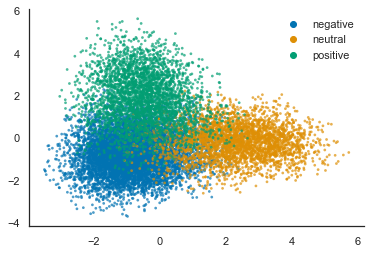

removed 41 outliers
removed 33 outliers
removed 35 outliers


<AxesSubplot:xlabel='0', ylabel='1'>

Text(0.5, 0, '')

Text(0, 0.5, '')

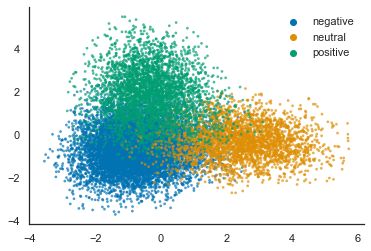

removed 61 outliers
removed 37 outliers
removed 34 outliers


<AxesSubplot:xlabel='0', ylabel='1'>

Text(0.5, 0, '')

Text(0, 0.5, '')

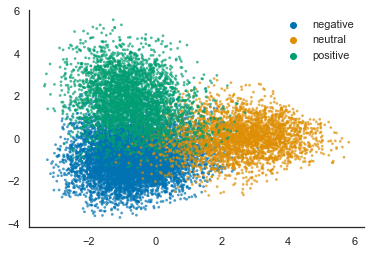

removed 47 outliers
removed 17 outliers
removed 44 outliers


<AxesSubplot:xlabel='0', ylabel='1'>

Text(0.5, 0, '')

Text(0, 0.5, '')

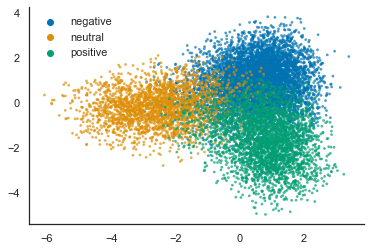

removed 45 outliers
removed 35 outliers
removed 34 outliers


<AxesSubplot:xlabel='0', ylabel='1'>

Text(0.5, 0, '')

Text(0, 0.5, '')

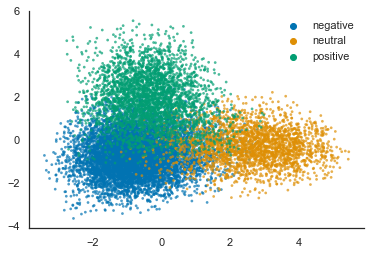

accuracy  balanced_accuracy  adjusted_ba        f1    g-mean
0  0.627976           0.522451     0.283677  0.594040  0.606978
1  0.550589           0.533585     0.300377  0.535729  0.635987
2  0.575651           0.511950     0.267925  0.579771  0.624573
3  0.606856           0.506453     0.259680  0.597387  0.636755
4  0.573854           0.552370     0.328555  0.571236  0.653505

mean accuracy score 0.5869854490717853
mean balanced_accuracy score 0.5253619210050471
mean adjusted_ba score 0.28804288150757057
mean f1 score 0.5756325583757933
mean g-mean score 0.6315596459713106
time: 2min 16s


In [49]:
scores = {
    "accuracy": [],
    "balanced_accuracy": [],
    "adjusted_ba": [],
    "f1": [],
    "g-mean": [],
}

for train_idx, test_idx in StratifiedGroupKFold(
    n_splits=5, shuffle=True, random_state=SEED
).split(X=data, y=test_labels.valence, groups=test_labels.speaker_id):
    # load
    X_train = data.iloc[train_idx]

    # remove outliers
    X_train = X_train.loc[LocalOutlierFactor(n_jobs=-1).fit_predict(X_train) == 1]
    train_index = X_train.index
    y_train = test_labels.loc[train_index].valence

    # reduce dimensions
    reducer = LinearDiscriminantAnalysis().fit(X_train, y_train)
    X_train = pd.DataFrame(reducer.transform(X_train))
    X_train.index = train_index
    del train_index
    _ = gc_collect()

    # remove outliers per class
    X_train = pd.concat([remove_outliers(X_train.loc[y_train == i]) for i in range(3)])
    y_train = test_labels.loc[X_train.index].valence

    # visualize
    sns.scatterplot(
        x=X_train[0],
        y=X_train[1],
        hue=y_train.replace([0, 1, 2], ["negative", "neutral", "positive"]),
        palette="colorblind",
        alpha=0.7,
        legend="brief",
        linewidth=0,
        marker=".",
        s=30,
    )
    sns.despine(**dict.fromkeys(("top", "right"), True))
    plt.legend(frameon=False)
    plt.xlabel("")
    plt.ylabel("")
    plt.show()

    # initialize model
    model = GaussianNB().fit(X_train, y_train)
    del X_train
    del y_train
    _ = gc_collect()

    # load and predict y
    y_pred = model.predict(reducer.transform(data.iloc[test_idx]))
    del model
    del reducer
    _ = gc_collect()
    y_test = test_labels.iloc[test_idx].valence

    # score
    scores["accuracy"].append(accuracy_score(y_test, y_pred))
    scores["balanced_accuracy"].append(balanced_accuracy_score(y_test, y_pred))
    scores["adjusted_ba"].append(balanced_accuracy_score(y_test, y_pred, adjusted=True))
    scores["f1"].append(f1_score(y_test, y_pred, average="weighted"))
    scores["g-mean"].append(geometric_mean_score(y_test, y_pred, average="weighted"))

    del y_test
    del y_pred
    _ = gc_collect()

results = pd.DataFrame(scores)
results
for column in results.columns:
    print(f"mean {column} score {results[column].mean()}")

removed 36 outliers
removed 26 outliers
removed 30 outliers


<AxesSubplot:xlabel='0', ylabel='1'>

Text(0.5, 0, '')

Text(0, 0.5, '')

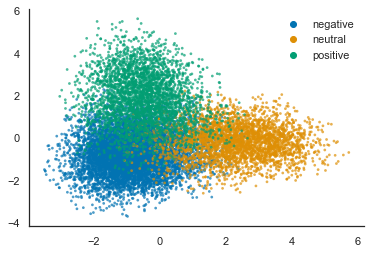

removed 41 outliers
removed 33 outliers
removed 35 outliers


<AxesSubplot:xlabel='0', ylabel='1'>

Text(0.5, 0, '')

Text(0, 0.5, '')

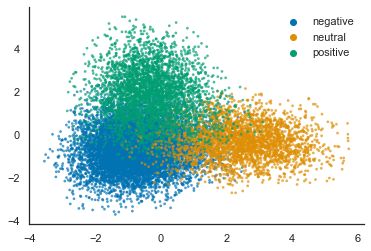

removed 61 outliers
removed 37 outliers
removed 34 outliers


<AxesSubplot:xlabel='0', ylabel='1'>

Text(0.5, 0, '')

Text(0, 0.5, '')

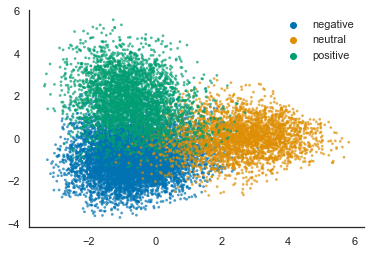

removed 47 outliers
removed 17 outliers
removed 44 outliers


<AxesSubplot:xlabel='0', ylabel='1'>

Text(0.5, 0, '')

Text(0, 0.5, '')

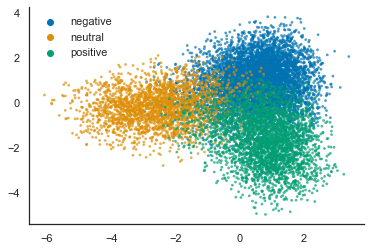

removed 45 outliers
removed 35 outliers
removed 34 outliers


<AxesSubplot:xlabel='0', ylabel='1'>

Text(0.5, 0, '')

Text(0, 0.5, '')

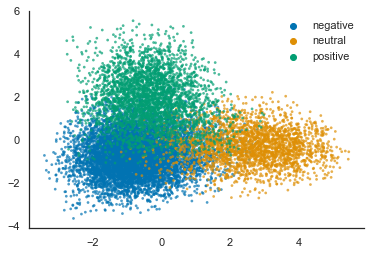

accuracy  balanced_accuracy  adjusted_ba        f1    g-mean
0  0.627381           0.517826     0.276739  0.593618  0.607851
1  0.544088           0.525249     0.287873  0.531006  0.629424
2  0.577596           0.510430     0.265646  0.582337  0.626343
3  0.594715           0.497029     0.245544  0.588101  0.627215
4  0.567385           0.545081     0.317622  0.564490  0.648203

mean accuracy score 0.5822331323584116
mean balanced_accuracy score 0.519123104305866
mean adjusted_ba score 0.2786846564587988
mean f1 score 0.5719103103758405
mean g-mean score 0.6278071012238631
time: 2min 34s


In [50]:
scores = {
    "accuracy": [],
    "balanced_accuracy": [],
    "adjusted_ba": [],
    "f1": [],
    "g-mean": [],
}

for train_idx, test_idx in StratifiedGroupKFold(
    n_splits=5, shuffle=True, random_state=SEED
).split(X=data, y=test_labels.valence, groups=test_labels.speaker_id):
    # load
    X_train = data.iloc[train_idx]

    # remove outliers
    X_train = X_train.loc[LocalOutlierFactor(n_jobs=-1).fit_predict(X_train) == 1]
    train_index = X_train.index
    y_train = test_labels.loc[train_index].valence

    # reduce dimensions
    reducer = LinearDiscriminantAnalysis().fit(X_train, y_train)
    X_train = pd.DataFrame(reducer.transform(X_train))
    X_train.index = train_index
    del train_index
    _ = gc_collect()

    # remove outliers per class
    X_train = pd.concat([remove_outliers(X_train.loc[y_train == i]) for i in range(3)])
    y_train = test_labels.loc[X_train.index].valence

    # visualize
    sns.scatterplot(
        x=X_train[0],
        y=X_train[1],
        hue=y_train.replace([0, 1, 2], ["negative", "neutral", "positive"]),
        palette="colorblind",
        alpha=0.7,
        legend="brief",
        linewidth=0,
        marker=".",
        s=30,
    )
    sns.despine(**dict.fromkeys(("top", "right"), True))
    plt.legend(frameon=False)
    plt.xlabel("")
    plt.ylabel("")
    plt.show()

    # initialize model
    model = BaggingClassifier(
        base_estimator=RandomForestClassifier(
            n_jobs=-1, random_state=SEED, class_weight="balanced"
        ),
        n_jobs=-1,
        random_state=SEED,
    ).fit(X_train, y_train)
    del X_train
    del y_train
    _ = gc_collect()

    # load and predict y
    y_pred = model.predict(reducer.transform(data.iloc[test_idx]))
    del model
    del reducer
    _ = gc_collect()
    y_test = test_labels.iloc[test_idx].valence

    # score
    scores["accuracy"].append(accuracy_score(y_test, y_pred))
    scores["balanced_accuracy"].append(balanced_accuracy_score(y_test, y_pred))
    scores["adjusted_ba"].append(balanced_accuracy_score(y_test, y_pred, adjusted=True))
    scores["f1"].append(f1_score(y_test, y_pred, average="weighted"))
    scores["g-mean"].append(geometric_mean_score(y_test, y_pred, average="weighted"))

    del y_test
    del y_pred
    _ = gc_collect()

results = pd.DataFrame(scores)
results
for column in results.columns:
    print(f"mean {column} score {results[column].mean()}")

removed 36 outliers
removed 26 outliers
removed 30 outliers


<AxesSubplot:xlabel='0', ylabel='1'>

Text(0.5, 0, '')

Text(0, 0.5, '')

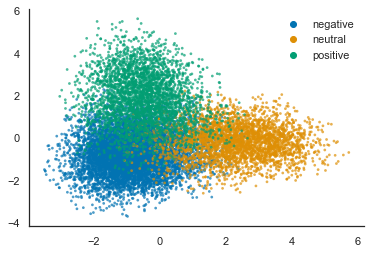

removed 41 outliers
removed 33 outliers
removed 35 outliers


<AxesSubplot:xlabel='0', ylabel='1'>

Text(0.5, 0, '')

Text(0, 0.5, '')

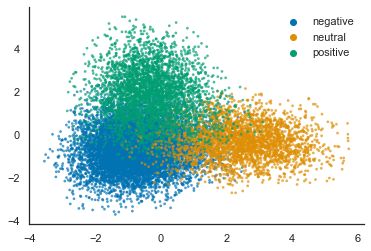

removed 61 outliers
removed 37 outliers
removed 34 outliers


<AxesSubplot:xlabel='0', ylabel='1'>

Text(0.5, 0, '')

Text(0, 0.5, '')

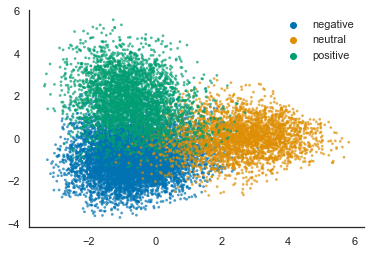

removed 47 outliers
removed 17 outliers
removed 44 outliers


<AxesSubplot:xlabel='0', ylabel='1'>

Text(0.5, 0, '')

Text(0, 0.5, '')

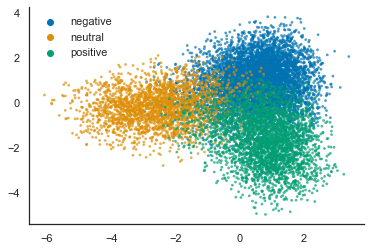

removed 45 outliers
removed 35 outliers
removed 34 outliers


<AxesSubplot:xlabel='0', ylabel='1'>

Text(0.5, 0, '')

Text(0, 0.5, '')

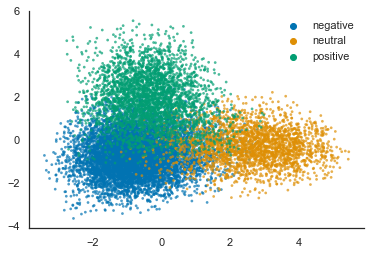

accuracy  balanced_accuracy  adjusted_ba        f1    g-mean
0  0.628274           0.521423     0.282135  0.595226  0.609631
1  0.541650           0.523890     0.285834  0.528769  0.627771
2  0.574874           0.509296     0.263944  0.579920  0.623541
3  0.594180           0.497942     0.246913  0.588256  0.628737
4  0.567116           0.545151     0.317726  0.564267  0.648006

mean accuracy score 0.5812185298390132
mean balanced_accuracy score 0.519540357424236
mean adjusted_ba score 0.27931053613635387
mean f1 score 0.5712876896939699
mean g-mean score 0.6275372816035704
time: 2min 42s


In [51]:
scores = {
    "accuracy": [],
    "balanced_accuracy": [],
    "adjusted_ba": [],
    "f1": [],
    "g-mean": [],
}

for train_idx, test_idx in StratifiedGroupKFold(
    n_splits=5, shuffle=True, random_state=SEED
).split(X=data, y=test_labels.valence, groups=test_labels.speaker_id):
    # load
    X_train = data.iloc[train_idx]

    # remove outliers
    X_train = X_train.loc[LocalOutlierFactor(n_jobs=-1).fit_predict(X_train) == 1]
    train_index = X_train.index
    y_train = test_labels.loc[train_index].valence

    # reduce dimensions
    reducer = LinearDiscriminantAnalysis().fit(X_train, y_train)
    X_train = pd.DataFrame(reducer.transform(X_train))
    X_train.index = train_index
    del train_index
    _ = gc_collect()

    # remove outliers per class
    X_train = pd.concat([remove_outliers(X_train.loc[y_train == i]) for i in range(3)])
    y_train = test_labels.loc[X_train.index].valence

    # visualize
    sns.scatterplot(
        x=X_train[0],
        y=X_train[1],
        hue=y_train.replace([0, 1, 2], ["negative", "neutral", "positive"]),
        palette="colorblind",
        alpha=0.7,
        legend="brief",
        linewidth=0,
        marker=".",
        s=30,
    )
    sns.despine(**dict.fromkeys(("top", "right"), True))
    plt.legend(frameon=False)
    plt.xlabel("")
    plt.ylabel("")
    plt.show()

    # initialize model
    model = BaggingClassifier(
        base_estimator=RandomForestClassifier(n_jobs=-1, random_state=SEED),
        n_jobs=-1,
        random_state=SEED,
    ).fit(X_train, y_train)
    del X_train
    del y_train
    _ = gc_collect()

    # load and predict y
    y_pred = model.predict(reducer.transform(data.iloc[test_idx]))
    del model
    del reducer
    _ = gc_collect()
    y_test = test_labels.iloc[test_idx].valence

    # score
    scores["accuracy"].append(accuracy_score(y_test, y_pred))
    scores["balanced_accuracy"].append(balanced_accuracy_score(y_test, y_pred))
    scores["adjusted_ba"].append(balanced_accuracy_score(y_test, y_pred, adjusted=True))
    scores["f1"].append(f1_score(y_test, y_pred, average="weighted"))
    scores["g-mean"].append(geometric_mean_score(y_test, y_pred, average="weighted"))

    del y_test
    del y_pred
    _ = gc_collect()

results = pd.DataFrame(scores)
results
for column in results.columns:
    print(f"mean {column} score {results[column].mean()}")

removed 36 outliers
removed 26 outliers
removed 30 outliers


<AxesSubplot:xlabel='0', ylabel='1'>

Text(0.5, 0, '')

Text(0, 0.5, '')

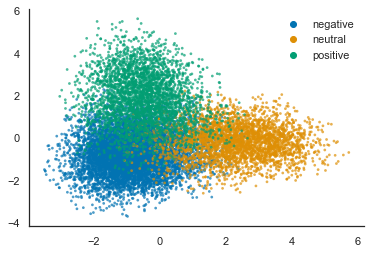

removed 41 outliers
removed 33 outliers
removed 35 outliers


<AxesSubplot:xlabel='0', ylabel='1'>

Text(0.5, 0, '')

Text(0, 0.5, '')

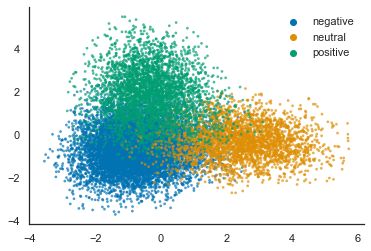

removed 61 outliers
removed 37 outliers
removed 34 outliers


<AxesSubplot:xlabel='0', ylabel='1'>

Text(0.5, 0, '')

Text(0, 0.5, '')

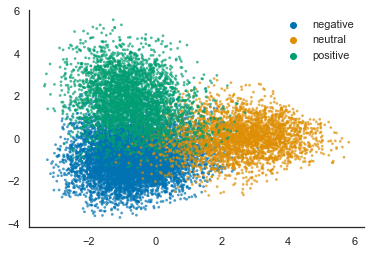

removed 47 outliers
removed 17 outliers
removed 44 outliers


<AxesSubplot:xlabel='0', ylabel='1'>

Text(0.5, 0, '')

Text(0, 0.5, '')

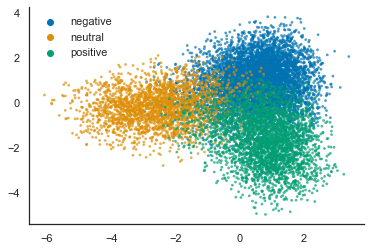

removed 45 outliers
removed 35 outliers
removed 34 outliers


<AxesSubplot:xlabel='0', ylabel='1'>

Text(0.5, 0, '')

Text(0, 0.5, '')

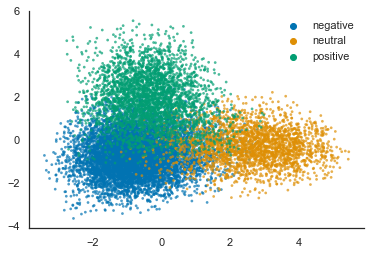

accuracy  balanced_accuracy  adjusted_ba        f1    g-mean
0  0.595833           0.524930     0.287395  0.583396  0.610389
1  0.552215           0.549948     0.324922  0.548736  0.645645
2  0.539479           0.519636     0.279454  0.554355  0.623328
3  0.575433           0.519632     0.279449  0.580207  0.640789
4  0.570081           0.571258     0.356887  0.571833  0.662759

mean accuracy score 0.5666081006444025
mean balanced_accuracy score 0.5370808567923417
mean adjusted_ba score 0.30562128518851245
mean f1 score 0.5677056133713176
mean g-mean score 0.6365821535203209
time: 2min 36s


In [52]:
scores = {
    "accuracy": [],
    "balanced_accuracy": [],
    "adjusted_ba": [],
    "f1": [],
    "g-mean": [],
}

for train_idx, test_idx in StratifiedGroupKFold(
    n_splits=5, shuffle=True, random_state=SEED
).split(X=data, y=test_labels.valence, groups=test_labels.speaker_id):
    # load
    X_train = data.iloc[train_idx]

    # remove outliers
    X_train = X_train.loc[LocalOutlierFactor(n_jobs=-1).fit_predict(X_train) == 1]
    train_index = X_train.index
    y_train = test_labels.loc[train_index].valence

    # reduce dimensions
    reducer = LinearDiscriminantAnalysis().fit(X_train, y_train)
    X_train = pd.DataFrame(reducer.transform(X_train))
    X_train.index = train_index
    del train_index
    _ = gc_collect()

    # remove outliers per class
    X_train = pd.concat([remove_outliers(X_train.loc[y_train == i]) for i in range(3)])
    y_train = test_labels.loc[X_train.index].valence

    # visualize
    sns.scatterplot(
        x=X_train[0],
        y=X_train[1],
        hue=y_train.replace([0, 1, 2], ["negative", "neutral", "positive"]),
        palette="colorblind",
        alpha=0.7,
        legend="brief",
        linewidth=0,
        marker=".",
        s=30,
    )
    sns.despine(**dict.fromkeys(("top", "right"), True))
    plt.legend(frameon=False)
    plt.xlabel("")
    plt.ylabel("")
    plt.show()

    # initialize model
    model = SVC(class_weight="balanced", random_state=SEED).fit(X_train, y_train)
    del X_train
    del y_train
    _ = gc_collect()

    # load and predict y
    y_pred = model.predict(reducer.transform(data.iloc[test_idx]))
    del model
    del reducer
    _ = gc_collect()
    y_test = test_labels.iloc[test_idx].valence

    # score
    scores["accuracy"].append(accuracy_score(y_test, y_pred))
    scores["balanced_accuracy"].append(balanced_accuracy_score(y_test, y_pred))
    scores["adjusted_ba"].append(balanced_accuracy_score(y_test, y_pred, adjusted=True))
    scores["f1"].append(f1_score(y_test, y_pred, average="weighted"))
    scores["g-mean"].append(geometric_mean_score(y_test, y_pred, average="weighted"))

    del y_test
    del y_pred
    _ = gc_collect()

results = pd.DataFrame(scores)
results
for column in results.columns:
    print(f"mean {column} score {results[column].mean()}")

removed 36 outliers
removed 26 outliers
removed 30 outliers


<AxesSubplot:xlabel='0', ylabel='1'>

Text(0.5, 0, '')

Text(0, 0.5, '')

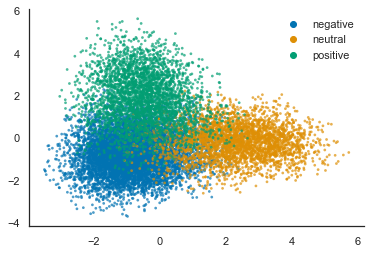

removed 41 outliers
removed 33 outliers
removed 35 outliers


<AxesSubplot:xlabel='0', ylabel='1'>

Text(0.5, 0, '')

Text(0, 0.5, '')

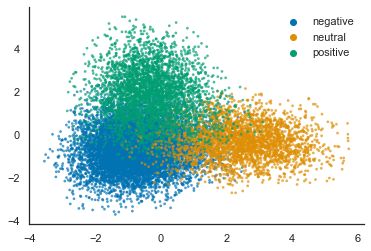

removed 61 outliers
removed 37 outliers
removed 34 outliers


<AxesSubplot:xlabel='0', ylabel='1'>

Text(0.5, 0, '')

Text(0, 0.5, '')

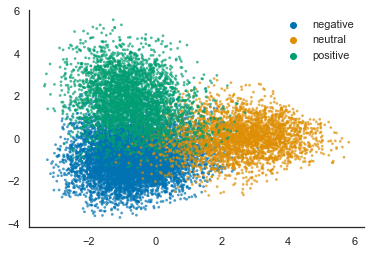

removed 47 outliers
removed 17 outliers
removed 44 outliers


<AxesSubplot:xlabel='0', ylabel='1'>

Text(0.5, 0, '')

Text(0, 0.5, '')

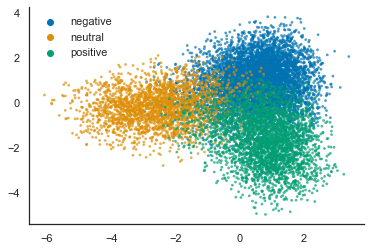

removed 45 outliers
removed 35 outliers
removed 34 outliers


<AxesSubplot:xlabel='0', ylabel='1'>

Text(0.5, 0, '')

Text(0, 0.5, '')

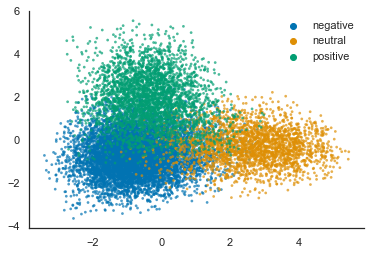

accuracy  balanced_accuracy  adjusted_ba        f1    g-mean
0  0.632738           0.512943     0.269415  0.592818  0.602641
1  0.546119           0.524706     0.287059  0.527422  0.630078
2  0.581875           0.503767     0.255650  0.582922  0.622222
3  0.612034           0.507144     0.260716  0.601728  0.637016
4  0.574124           0.546517     0.319775  0.569195  0.650083

mean accuracy score 0.5893779740855531
mean balanced_accuracy score 0.5190152518091554
mean adjusted_ba score 0.27852287771373313
mean f1 score 0.5748169221480495
mean g-mean score 0.6284080405626797
time: 2min 30s


In [53]:
scores = {
    "accuracy": [],
    "balanced_accuracy": [],
    "adjusted_ba": [],
    "f1": [],
    "g-mean": [],
}

for train_idx, test_idx in StratifiedGroupKFold(
    n_splits=5, shuffle=True, random_state=SEED
).split(X=data, y=test_labels.valence, groups=test_labels.speaker_id):
    # load
    X_train = data.iloc[train_idx]

    # remove outliers
    X_train = X_train.loc[LocalOutlierFactor(n_jobs=-1).fit_predict(X_train) == 1]
    train_index = X_train.index
    y_train = test_labels.loc[train_index].valence

    # reduce dimensions
    reducer = LinearDiscriminantAnalysis().fit(X_train, y_train)
    X_train = pd.DataFrame(reducer.transform(X_train))
    X_train.index = train_index
    del train_index
    _ = gc_collect()

    # remove outliers per class
    X_train = pd.concat([remove_outliers(X_train.loc[y_train == i]) for i in range(3)])
    y_train = test_labels.loc[X_train.index].valence

    # visualize
    sns.scatterplot(
        x=X_train[0],
        y=X_train[1],
        hue=y_train.replace([0, 1, 2], ["negative", "neutral", "positive"]),
        palette="colorblind",
        alpha=0.7,
        legend="brief",
        linewidth=0,
        marker=".",
        s=30,
    )
    sns.despine(**dict.fromkeys(("top", "right"), True))
    plt.legend(frameon=False)
    plt.xlabel("")
    plt.ylabel("")
    plt.show()

    # initialize model
    model = SVC(random_state=SEED).fit(X_train, y_train)
    del X_train
    del y_train
    _ = gc_collect()

    # load and predict y
    y_pred = model.predict(reducer.transform(data.iloc[test_idx]))
    del model
    del reducer
    _ = gc_collect()
    y_test = test_labels.iloc[test_idx].valence

    # score
    scores["accuracy"].append(accuracy_score(y_test, y_pred))
    scores["balanced_accuracy"].append(balanced_accuracy_score(y_test, y_pred))
    scores["adjusted_ba"].append(balanced_accuracy_score(y_test, y_pred, adjusted=True))
    scores["f1"].append(f1_score(y_test, y_pred, average="weighted"))
    scores["g-mean"].append(geometric_mean_score(y_test, y_pred, average="weighted"))

    del y_test
    del y_pred
    _ = gc_collect()

results = pd.DataFrame(scores)
results
for column in results.columns:
    print(f"mean {column} score {results[column].mean()}")

In [54]:
scores = {
    "accuracy": [],
    "balanced_accuracy": [],
    "adjusted_ba": [],
    "f1": [],
    "g-mean": [],
}

for train_idx, test_idx in StratifiedGroupKFold(
    n_splits=5, shuffle=True, random_state=SEED
).split(X=data, y=test_labels.valence, groups=test_labels.speaker_id):
    # load
    X_train = data.iloc[train_idx]

    # remove outliers
    X_train = X_train.loc[LocalOutlierFactor(n_jobs=-1).fit_predict(X_train) == 1]
    train_index = X_train.index
    y_train = test_labels.loc[train_index].valence

    # reduce dimensions
    reducer = LinearDiscriminantAnalysis().fit(X_train, y_train)
    X_train = pd.DataFrame(reducer.transform(X_train))
    X_train.index = train_index
    del train_index
    _ = gc_collect()

    # remove outliers per class
    X_train = pd.concat([remove_outliers(X_train.loc[y_train == i]) for i in range(3)])
    y_train = test_labels.loc[X_train.index].valence

    # # visualize
    # sns.scatterplot(
    #     x=X_train[0],
    #     y=X_train[1],
    #     hue=y_train.replace([0, 1, 2], ["negative", "neutral", "positive"]),
    #     palette="colorblind",
    #     alpha=0.7,
    #     legend="brief",
    #     linewidth=0,
    #     marker=".",
    #     s=30,
    # )
    # sns.despine(**dict.fromkeys(("top", "right"), True))
    # plt.legend(frameon=False)
    # plt.xlabel("")
    # plt.ylabel("")
    # plt.show()

    # initialize model
    model = PassiveAggressiveClassifier(
        n_jobs=-1, random_state=SEED, class_weight="balanced"
    ).fit(X_train, y_train)
    del X_train
    del y_train
    _ = gc_collect()

    # load and predict y
    y_pred = model.predict(reducer.transform(data.iloc[test_idx]))
    del model
    del reducer
    _ = gc_collect()
    y_test = test_labels.iloc[test_idx].valence

    # score
    scores["accuracy"].append(accuracy_score(y_test, y_pred))
    scores["balanced_accuracy"].append(balanced_accuracy_score(y_test, y_pred))
    scores["adjusted_ba"].append(balanced_accuracy_score(y_test, y_pred, adjusted=True))
    scores["f1"].append(f1_score(y_test, y_pred, average="weighted"))
    scores["g-mean"].append(geometric_mean_score(y_test, y_pred, average="weighted"))

    del y_test
    del y_pred
    _ = gc_collect()

results = pd.DataFrame(scores)
results
for column in results.columns:
    print(f"mean {column} score {results[column].mean()}")

removed 36 outliers
removed 26 outliers
removed 30 outliers
removed 41 outliers
removed 33 outliers
removed 35 outliers
removed 61 outliers
removed 37 outliers
removed 34 outliers
removed 47 outliers
removed 17 outliers
removed 44 outliers
removed 45 outliers
removed 35 outliers
removed 34 outliers


accuracy  balanced_accuracy  adjusted_ba        f1    g-mean
0  0.579762           0.524963     0.287444  0.563713  0.608555
1  0.555059           0.539172     0.308758  0.548624  0.641789
2  0.415403           0.458625     0.187937  0.425486  0.548862
3  0.595251           0.510044     0.265065  0.586052  0.641167
4  0.569272           0.557320     0.335980  0.563803  0.653665

mean accuracy score 0.5429492952509187
mean balanced_accuracy score 0.5180245811000991
mean adjusted_ba score 0.27703687165014873
mean f1 score 0.5375356151836023
mean g-mean score 0.6188074770531449
time: 2min 17s


In [56]:
scores = {
    "accuracy": [],
    "balanced_accuracy": [],
    "adjusted_ba": [],
    "f1": [],
    "g-mean": [],
}

for train_idx, test_idx in StratifiedGroupKFold(
    n_splits=5, shuffle=True, random_state=SEED
).split(X=data, y=test_labels.valence, groups=test_labels.speaker_id):
    # load
    X_train = data.iloc[train_idx]

    # remove outliers
    X_train = X_train.loc[LocalOutlierFactor(n_jobs=-1).fit_predict(X_train) == 1]
    train_index = X_train.index
    y_train = test_labels.loc[train_index].valence

    # reduce dimensions
    reducer = LinearDiscriminantAnalysis().fit(X_train, y_train)
    X_train = pd.DataFrame(reducer.transform(X_train))
    X_train.index = train_index
    del train_index
    _ = gc_collect()

    # remove outliers per class
    X_train = pd.concat([remove_outliers(X_train.loc[y_train == i]) for i in range(3)])
    y_train = test_labels.loc[X_train.index].valence

    # initialize model
    model = SGDClassifier(n_jobs=-1, random_state=SEED).fit(X_train, y_train)
    del X_train
    del y_train
    _ = gc_collect()

    # load and predict y
    y_pred = model.predict(reducer.transform(data.iloc[test_idx]))
    del model
    del reducer
    _ = gc_collect()
    y_test = test_labels.iloc[test_idx].valence

    # score
    scores["accuracy"].append(accuracy_score(y_test, y_pred))
    scores["balanced_accuracy"].append(balanced_accuracy_score(y_test, y_pred))
    scores["adjusted_ba"].append(balanced_accuracy_score(y_test, y_pred, adjusted=True))
    scores["f1"].append(f1_score(y_test, y_pred, average="weighted"))
    scores["g-mean"].append(geometric_mean_score(y_test, y_pred, average="weighted"))

    del y_test
    del y_pred
    _ = gc_collect()

results = pd.DataFrame(scores)
results
for column in results.columns:
    print(f"mean {column} score {results[column].mean()}")

removed 36 outliers
removed 26 outliers
removed 30 outliers
removed 41 outliers
removed 33 outliers
removed 35 outliers
removed 61 outliers
removed 37 outliers
removed 34 outliers
removed 47 outliers
removed 17 outliers
removed 44 outliers
removed 45 outliers
removed 35 outliers
removed 34 outliers


accuracy  balanced_accuracy  adjusted_ba        f1    g-mean
0  0.635714           0.516164     0.274246  0.604486  0.608670
1  0.553434           0.537160     0.305741  0.538380  0.639270
2  0.576429           0.509583     0.264375  0.582634  0.628954
3  0.597750           0.489041     0.233562  0.589391  0.620598
4  0.575741           0.555613     0.333420  0.573793  0.656936

mean accuracy score 0.5878137791626603
mean balanced_accuracy score 0.5215123978562295
mean adjusted_ba score 0.2822685967843442
mean f1 score 0.5777366931441663
mean g-mean score 0.6308855198603773
time: 2min 18s


In [57]:
scores = {
    "accuracy": [],
    "balanced_accuracy": [],
    "adjusted_ba": [],
    "f1": [],
    "g-mean": [],
}

for train_idx, test_idx in StratifiedGroupKFold(
    n_splits=5, shuffle=True, random_state=SEED
).split(X=data, y=test_labels.valence, groups=test_labels.speaker_id):
    # load
    X_train = data.iloc[train_idx]

    # remove outliers
    X_train = X_train.loc[LocalOutlierFactor(n_jobs=-1).fit_predict(X_train) == 1]
    train_index = X_train.index
    y_train = test_labels.loc[train_index].valence

    # reduce dimensions
    reducer = LinearDiscriminantAnalysis().fit(X_train, y_train)
    X_train = pd.DataFrame(reducer.transform(X_train))
    X_train.index = train_index
    del train_index
    _ = gc_collect()

    # remove outliers per class
    X_train = pd.concat([remove_outliers(X_train.loc[y_train == i]) for i in range(3)])
    y_train = test_labels.loc[X_train.index].valence

    # initialize model
    model = LinearSVC(random_state=SEED).fit(X_train, y_train)
    del X_train
    del y_train
    _ = gc_collect()

    # load and predict y
    y_pred = model.predict(reducer.transform(data.iloc[test_idx]))
    del model
    del reducer
    _ = gc_collect()
    y_test = test_labels.iloc[test_idx].valence

    # score
    scores["accuracy"].append(accuracy_score(y_test, y_pred))
    scores["balanced_accuracy"].append(balanced_accuracy_score(y_test, y_pred))
    scores["adjusted_ba"].append(balanced_accuracy_score(y_test, y_pred, adjusted=True))
    scores["f1"].append(f1_score(y_test, y_pred, average="weighted"))
    scores["g-mean"].append(geometric_mean_score(y_test, y_pred, average="weighted"))

    del y_test
    del y_pred
    _ = gc_collect()

results = pd.DataFrame(scores)
results
for column in results.columns:
    print(f"mean {column} score {results[column].mean()}")

removed 36 outliers
removed 26 outliers
removed 30 outliers
removed 41 outliers
removed 33 outliers
removed 35 outliers
removed 61 outliers
removed 37 outliers
removed 34 outliers
removed 47 outliers
removed 17 outliers
removed 44 outliers
removed 45 outliers
removed 35 outliers
removed 34 outliers


accuracy  balanced_accuracy  adjusted_ba        f1    g-mean
0  0.634524           0.522410     0.283615  0.598391  0.609513
1  0.548151           0.528296     0.292444  0.534157  0.633787
2  0.578763           0.512542     0.268813  0.583453  0.628185
3  0.606856           0.502806     0.254210  0.598229  0.633454
4  0.577358           0.552476     0.328714  0.573790  0.655952

mean accuracy score 0.5891305007859011
mean balanced_accuracy score 0.5237061445610884
mean adjusted_ba score 0.28555921684163255
mean f1 score 0.577603780969278
mean g-mean score 0.6321780632746264
time: 2min 12s


In [59]:
scores = {
    "accuracy": [],
    "balanced_accuracy": [],
    "adjusted_ba": [],
    "f1": [],
    "g-mean": [],
}

for train_idx, test_idx in StratifiedGroupKFold(
    n_splits=5, shuffle=True, random_state=SEED
).split(X=data, y=test_labels.valence, groups=test_labels.speaker_id):
    # load
    X_train = data.iloc[train_idx]

    # remove outliers
    X_train = X_train.loc[LocalOutlierFactor(n_jobs=-1).fit_predict(X_train) == 1]
    train_index = X_train.index
    y_train = test_labels.loc[train_index].valence

    # reduce dimensions
    reducer = LinearDiscriminantAnalysis().fit(X_train, y_train)
    X_train = pd.DataFrame(reducer.transform(X_train))
    X_train.index = train_index
    del train_index
    _ = gc_collect()

    # remove outliers per class
    X_train = pd.concat([remove_outliers(X_train.loc[y_train == i]) for i in range(3)])
    y_train = test_labels.loc[X_train.index].valence

    # initialize model
    model = LogisticRegressionCV(
        scoring="balanced_accuracy", n_jobs=-1, random_state=SEED
    ).fit(X_train, y_train)
    del X_train
    del y_train
    _ = gc_collect()

    # load and predict y
    y_pred = model.predict(reducer.transform(data.iloc[test_idx]))
    del model
    del reducer
    _ = gc_collect()
    y_test = test_labels.iloc[test_idx].valence

    # score
    scores["accuracy"].append(accuracy_score(y_test, y_pred))
    scores["balanced_accuracy"].append(balanced_accuracy_score(y_test, y_pred))
    scores["adjusted_ba"].append(balanced_accuracy_score(y_test, y_pred, adjusted=True))
    scores["f1"].append(f1_score(y_test, y_pred, average="weighted"))
    scores["g-mean"].append(geometric_mean_score(y_test, y_pred, average="weighted"))

    del y_test
    del y_pred
    _ = gc_collect()

results = pd.DataFrame(scores)
results
for column in results.columns:
    print(f"mean {column} score {results[column].mean()}")

removed 36 outliers
removed 26 outliers
removed 30 outliers
removed 41 outliers
removed 33 outliers
removed 35 outliers
removed 61 outliers
removed 37 outliers
removed 34 outliers
removed 47 outliers
removed 17 outliers
removed 44 outliers
removed 45 outliers
removed 35 outliers
removed 34 outliers


accuracy  balanced_accuracy  adjusted_ba        f1    g-mean
0  0.628274           0.518513     0.277770  0.594939  0.605956
1  0.548964           0.528964     0.293446  0.535055  0.633691
2  0.575651           0.506662     0.259993  0.579969  0.623733
3  0.606142           0.508794     0.263191  0.599094  0.637523
4  0.571968           0.549072     0.323608  0.568994  0.651944

mean accuracy score 0.5861997116442303
mean balanced_accuracy score 0.5224010773636021
mean adjusted_ba score 0.2836016160454031
mean f1 score 0.5756103504371708
mean g-mean score 0.6305692541469996
time: 2min 24s


In [61]:
scores = {
    "accuracy": [],
    "balanced_accuracy": [],
    "adjusted_ba": [],
    "f1": [],
    "g-mean": [],
}

for train_idx, test_idx in StratifiedGroupKFold(
    n_splits=5, shuffle=True, random_state=SEED
).split(X=data, y=test_labels.valence, groups=test_labels.speaker_id):
    # load
    X_train = data.iloc[train_idx]

    # remove outliers
    X_train = X_train.loc[LocalOutlierFactor(n_jobs=-1).fit_predict(X_train) == 1]
    train_index = X_train.index
    y_train = test_labels.loc[train_index].valence

    # reduce dimensions
    reducer = LinearDiscriminantAnalysis().fit(X_train, y_train)
    X_train = pd.DataFrame(reducer.transform(X_train))
    X_train.index = train_index
    del train_index
    _ = gc_collect()

    # remove outliers per class
    X_train = pd.concat([remove_outliers(X_train.loc[y_train == i]) for i in range(3)])
    y_train = test_labels.loc[X_train.index].valence

    # initialize model
    model = RidgeClassifierCV(scoring="balanced_accuracy", class_weight="balanced").fit(
        X_train, y_train
    )
    del X_train
    del y_train
    _ = gc_collect()

    # load and predict y
    y_pred = model.predict(reducer.transform(data.iloc[test_idx]))
    del model
    del reducer
    _ = gc_collect()
    y_test = test_labels.iloc[test_idx].valence

    # score
    scores["accuracy"].append(accuracy_score(y_test, y_pred))
    scores["balanced_accuracy"].append(balanced_accuracy_score(y_test, y_pred))
    scores["adjusted_ba"].append(balanced_accuracy_score(y_test, y_pred, adjusted=True))
    scores["f1"].append(f1_score(y_test, y_pred, average="weighted"))
    scores["g-mean"].append(geometric_mean_score(y_test, y_pred, average="weighted"))

    del y_test
    del y_pred
    _ = gc_collect()

results = pd.DataFrame(scores)
results
for column in results.columns:
    print(f"mean {column} score {results[column].mean()}")

removed 36 outliers
removed 26 outliers
removed 30 outliers
removed 41 outliers
removed 33 outliers
removed 35 outliers
removed 61 outliers
removed 37 outliers
removed 34 outliers
removed 47 outliers
removed 17 outliers
removed 44 outliers
removed 45 outliers
removed 35 outliers
removed 34 outliers


accuracy  balanced_accuracy  adjusted_ba        f1    g-mean
0  0.604762           0.530290     0.295434  0.589186  0.614525
1  0.550589           0.546628     0.319942  0.546363  0.644264
2  0.547258           0.523027     0.284540  0.561606  0.628454
3  0.582575           0.517326     0.275990  0.584667  0.640014
4  0.572507           0.571682     0.357523  0.574137  0.664071

mean accuracy score 0.5715380502530761
mean balanced_accuracy score 0.5377906458964893
mean adjusted_ba score 0.3066859688447339
mean f1 score 0.5711917808231333
mean g-mean score 0.6382657983223671
time: 2min 9s


In [62]:
scores = {
    "accuracy": [],
    "balanced_accuracy": [],
    "adjusted_ba": [],
    "f1": [],
    "g-mean": [],
}

for train_idx, test_idx in StratifiedGroupKFold(
    n_splits=5, shuffle=True, random_state=SEED
).split(X=data, y=test_labels.valence, groups=test_labels.speaker_id):
    # load
    X_train = data.iloc[train_idx]

    # remove outliers
    X_train = X_train.loc[LocalOutlierFactor(n_jobs=-1).fit_predict(X_train) == 1]
    train_index = X_train.index
    y_train = test_labels.loc[train_index].valence

    # reduce dimensions
    reducer = LinearDiscriminantAnalysis().fit(X_train, y_train)
    X_train = pd.DataFrame(reducer.transform(X_train))
    X_train.index = train_index
    del train_index
    _ = gc_collect()

    # remove outliers per class
    X_train = pd.concat([remove_outliers(X_train.loc[y_train == i]) for i in range(3)])
    y_train = test_labels.loc[X_train.index].valence

    # initialize model
    model = RidgeClassifierCV(scoring="balanced_accuracy").fit(X_train, y_train)
    del X_train
    del y_train
    _ = gc_collect()

    # load and predict y
    y_pred = model.predict(reducer.transform(data.iloc[test_idx]))
    del model
    del reducer
    _ = gc_collect()
    y_test = test_labels.iloc[test_idx].valence

    # score
    scores["accuracy"].append(accuracy_score(y_test, y_pred))
    scores["balanced_accuracy"].append(balanced_accuracy_score(y_test, y_pred))
    scores["adjusted_ba"].append(balanced_accuracy_score(y_test, y_pred, adjusted=True))
    scores["f1"].append(f1_score(y_test, y_pred, average="weighted"))
    scores["g-mean"].append(geometric_mean_score(y_test, y_pred, average="weighted"))

    del y_test
    del y_pred
    _ = gc_collect()

results = pd.DataFrame(scores)
results
for column in results.columns:
    print(f"mean {column} score {results[column].mean()}")

removed 36 outliers
removed 26 outliers
removed 30 outliers
removed 41 outliers
removed 33 outliers
removed 35 outliers
removed 61 outliers
removed 37 outliers
removed 34 outliers
removed 47 outliers
removed 17 outliers
removed 44 outliers
removed 45 outliers
removed 35 outliers
removed 34 outliers


accuracy  balanced_accuracy  adjusted_ba        f1    g-mean
0  0.633929           0.519260     0.278890  0.593931  0.605002
1  0.543275           0.520579     0.280869  0.524982  0.628818
2  0.585375           0.511330     0.266995  0.587632  0.630765
3  0.610605           0.497812     0.246718  0.598588  0.630195
4  0.577628           0.548531     0.322796  0.572313  0.653757

mean accuracy score 0.5901624569194004
mean balanced_accuracy score 0.5195023452734098
mean adjusted_ba score 0.27925351791011466
mean f1 score 0.5754891100968171
mean g-mean score 0.6297072292395292
time: 2min 10s


I forgot to record the results in a table, but here are the scores with 5 folds for LOF-LDA-per_class_LOF:
* accuracy
  * RidgeClassifierCV: 0.5901624569194004
  * SVC: 0.5893779740855531
  * LinearSVC: 0.5891305007859011
  * SGDClassifier: 0.5878137791626603
  * GaussianProcessClassifier: 0.5870374964133976
  * GaussianNB: 0.5869854490717853
  * LinearDiscriminantAnalysis: 0.5869620116683917
  * LogisticRegressionCV: 0.5861997116442303
  * BaggingClassifier, rf, class_weight="balanced": 0.5822331323584116
  * BaggingClassifier, rf: 0.5812185298390132
  * LinearSVC, class_weight="balanced": 0.5771815900367802
  * SGDClassifier, class_weight="balanced": 0.5763139527465022
  * KNeighborsClassifier: 0.5760291839438129
  * RidgeClassifierCV, class_weight="balanced": 0.5715380502530761
  * LogisticRegressionCV, class_weight="balanced": 0.5677342844447879
  * SVC, class_weight="balanced": 0.5666081006444025
  * PassiveAggressiveClassifier: 0.5429492952509187
* balanced accuracy
  * RidgeClassifierCV, class_weight="balanced": 0.5377906458964893
  * LogisticRegressionCV, class_weight="balanced": 0.5365654377274682
  * SGDClassifier, class_weight="balanced": 0.5322620371549625
  * LinearSVC, class_weight="balanced": 0.5308855333830994
  * GaussianNB: 0.5253619210050471
  * LinearSVC: 0.5237061445610884
  * LogisticRegressionCV: 0.5224010773636021
  * GaussianProcessClassifier: 0.5221575448124037
  * SGDClassifier: 0.5215123978562295
  * LinearDiscriminantAnalysis: 0.521238402602787
  * BaggingClassifier, rf: 0.519540357424236
  * BaggingClassifier, rf, class_weight="balanced": 0.519123104305866
  * SVC, class_weight="balanced": 0.5370808567923417
  * RidgeClassifierCV: 0.5195023452734098
  * SVC: 0.5190152518091554
  * PassiveAggressiveClassifier: 0.5180245811000991
  * KNeighborsClassifier: 0.5103337440330897
* balanced accuracy (adjusted)
  * RidgeClassifierCV, class_weight="balanced": 0.3066859688447339
  * SVC, class_weight="balanced": 0.30562128518851245
  * LogisticRegressionCV, class_weight="balanced": 0.30484815659120235
  * SGDClassifier, class_weight="balanced": 0.2983930557324437
  * LinearSVC, class_weight="balanced": 0.29632830007464916
  * GaussianNB: 0.28804288150757057
  * LinearSVC: 0.28555921684163255
  * LogisticRegressionCV: 0.2836016160454031
  * SGDClassifier: 0.2822685967843442
  * GaussianProcessClassifier: 0.28323631721860565
  * LinearDiscriminantAnalysis: 0.2818576039041804
  * BaggingClassifier, rf: 0.27931053613635387
  * RidgeClassifierCV: 0.27925351791011466
  * BaggingClassifier, rf, class_weight="balanced": 0.2786846564587988
  * SVC: 0.27852287771373313
  * PassiveAggressiveClassifier: 0.27703687165014873
  * KNeighborsClassifier: 0.2655006160496346
* F1
  * SGDClassifier: 0.5777366931441663
  * LinearSVC: 0.577603780969278
  * GaussianNB: 0.5756325583757933
  * LogisticRegressionCV: 0.5756103504371708
  * GaussianProcessClassifier: 0.5754893007815751
  * RidgeClassifierCV: 0.5754891100968171
  * SGDClassifier, class_weight="balanced": 0.5749328617458996
  * SVC: 0.5748169221480495
  * LinearDiscriminantAnalysis: 0.5744326898901084
  * LinearSVC, class_weight="balanced": 0.5732878021220349
  * BaggingClassifier, rf, class_weight="balanced": 0.5719103103758405
  * BaggingClassifier, rf: 0.5712876896939699
  * RidgeClassifierCV, class_weight="balanced": 0.5711917808231333
  * LogisticRegressionCV, class_weight="balanced": 0.5684530233903529
  * SVC, class_weight="balanced": 0.5677056133713176
  * KNeighborsClassifier: 0.5640971883681413
  * PassiveAggressiveClassifier: 0.5375356151836023
* G-mean
  * RidgeClassifierCV, class_weight="balanced": 0.6382657983223671
  * SVC, class_weight="balanced": 0.6365821535203209
  * LogisticRegressionCV, class_weight="balanced": 0.6365002954316786
  * SGDClassifier, class_weight="balanced": 0.6357432629762567
  * LinearSVC, class_weight="balanced": 0.6348837846406694
  * LinearSVC: 0.6321780632746264
  * GaussianNB: 0.6315596459713106
  * SGDClassifier: 0.6308855198603773
  * LogisticRegressionCV: 0.6305692541469996
  * GaussianProcessClassifier: 0.6304906903300453
  * RidgeClassifierCV: 0.6297072292395292
  * LinearDiscriminantAnalysis: 0.6290565250295219
  * SVC: 0.6284080405626797
  * BaggingClassifier, rf, class_weight="balanced": 0.6278071012238631
  * BaggingClassifier, rf: 0.6275372816035704
  * KNeighborsClassifier: 0.6197899370766083
  * PassiveAggressiveClassifier: 0.6188074770531449

RidgeClassifierCV is first place by accuracy. SVC is second place by accuracy. LinearSVC is third place by accuracy and second place by F1. RidgeClassifierCV (class_weight="balanced") is first place by balanced accuracy, first place by adjusted balanced accuracy, and first place by geometric mean. LogisticRegressionCV (class_weight="balanced") is second place by balanced accuracy, third place by adjusted balanced accuracy, and third place by geometric mean. SVC (class_weight="balanced) was second place by adjusted balanced accuracy and second place by geometric mean. SGDClassifier (class_weight="balanced") is third place by balanced accuracy and first place by F1. GaussianNB is third place by F1.

These are the models that ranked in the top three by each metric and thus we will continue to test them. Let's visualize their decision regions.

In [55]:
X_data = data.loc[LocalOutlierFactor(n_jobs=-1).fit_predict(data) == 1]
y_data = labels.loc[X_data.index].valence
_ = LinearDiscriminantAnalysis().fit_transform(X_data, y_data)
X_data = pd.DataFrame({"X": _[:, 0], "Y": _[:, 1]})
del _
_ = gc_collect()
X_data.index = y_data.index
_ = gc_collect()
y_data = labels.loc[X_data.index].valence
X_data = pd.concat([remove_outliers(X_data.loc[y_data == i]) for i in range(3)])
y_data = labels.loc[X_data.index].valence
X_data.head()
X_data.info()
y_data

removed 42 outliers
removed 32 outliers
removed 44 outliers


X         Y
id                    
0  -0.523149 -0.963034
2  -2.004389 -0.155702
4  -0.291848 -0.802536
6   0.364508 -1.154988
8  -2.025395 -1.392042

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 17129 entries, 0 to 38045
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       17129 non-null  float64
 1   Y       17129 non-null  float64
dtypes: float64(2)
memory usage: 401.5 KB


id
0        0
2        0
4        0
6        0
8        0
        ..
38041    2
38042    2
38043    2
38044    2
38045    2
Name: valence, Length: 17129, dtype: int8

time: 40.6 s


SGDClassifier(class_weight='balanced', n_jobs=-1, random_state=2021)


<AxesSubplot:>

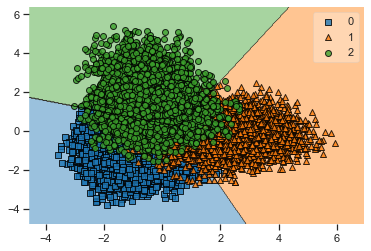

SVC(random_state=2021)


<AxesSubplot:>

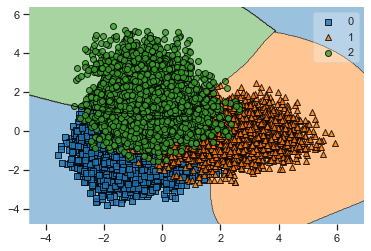

SVC(class_weight='balanced', random_state=2021)


<AxesSubplot:>

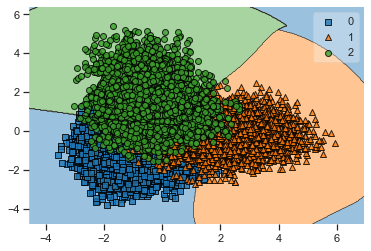

GaussianNB()


<AxesSubplot:>

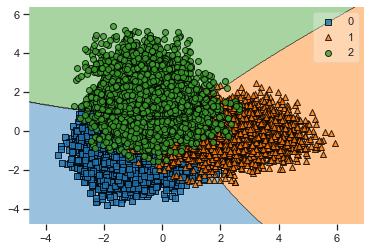

LinearSVC(random_state=2021)


<AxesSubplot:>

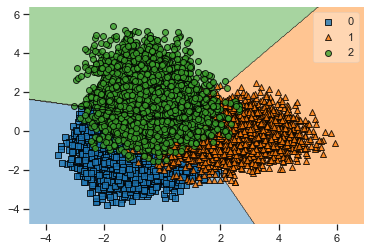

LogisticRegressionCV(class_weight='balanced', n_jobs=-1, random_state=2021,
                     scoring='balanced_accuracy')


<AxesSubplot:>

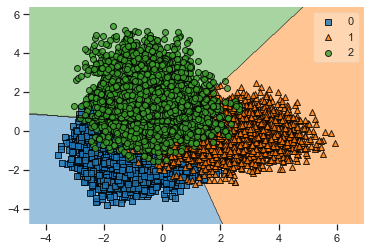

RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ]), class_weight='balanced',
                  scoring='balanced_accuracy')


<AxesSubplot:>

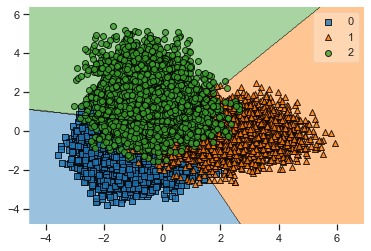

RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ]), scoring='balanced_accuracy')


<AxesSubplot:>

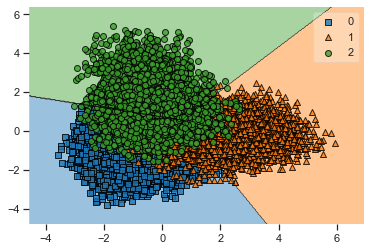

SGDClassifier(n_jobs=-1, random_state=2021)


<AxesSubplot:>

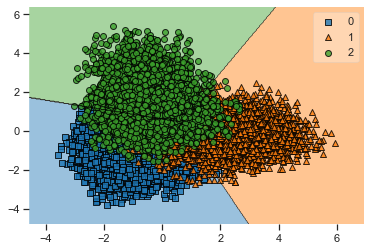

time: 13min 28s


In [66]:
for model in {
    GaussianNB(),
    LinearSVC(random_state=SEED),
    LogisticRegressionCV(
        scoring="balanced_accuracy",
        class_weight="balanced",
        n_jobs=-1,
        random_state=SEED,
    ),
    RidgeClassifierCV(scoring="balanced_accuracy", class_weight="balanced"),
    RidgeClassifierCV(scoring="balanced_accuracy"),
    SGDClassifier(n_jobs=-1, random_state=SEED),
    SGDClassifier(n_jobs=-1, random_state=SEED, class_weight="balanced"),
    SVC(random_state=SEED),
    SVC(class_weight="balanced", random_state=SEED),
}:
    print(model)
    plot_decision_regions(
        X_data.values, y_data.values, clf=model.fit(X_data.values, y_data.values)
    )
    plt.show()

Every transformation we attempted appeared to improve performance. However, it is crucial to test these conditions again since we're using the dev set. Although there was cross validation runs at the beginning and end of this notebook, other transformations were performed across those folds pre-split, so the results that aren't cross-validated are probably overfit.

This appears to be a promising technique, but it may need to meet a critical threshold of data points in order to be effective. The 3-fold cross validation produced worse visualizations compared to the 5-fold.

The plots reveal three clear centroids. We used LOF to remove outliers from the whole dev set, reduced dimensions with LDA, and then used LOF to remove per-class outliers. In cross validation, this would take place in-fold. I don't know if this is kosher, but if it ends up working and no data leaks, why not? 2048 -> 2 features is some major compression.

There is actually a tiny bit of leakage since the dev set is later merged back into the full dataset and new train-test splits made. However, if we cross-validate everything, no data should leak during training and it should be fine.

Intuitively, I think a trio of calibrated one-class SVMs could work well. You could also combine that with a trio of per-class LOF scores. Further, you could take the two LDA components, the SVM probability trio, the LOF feature trio, and the 1,024 FRILL features and cascade them all to a dense network.

Next steps are to pre-compute these in-fold transformations on the full data and store them on disk (with additional testing at each step). Then we can look into resampling.

In [67]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time:.1f} s")
_ = gc_collect()

Time elapsed since notebook_begin_time: 14783.1 s
time: 157 ms


[^top](#Contents)